# Imports

In [7]:
root_path = "/mnt/c/Users/diego/OneDrive/Documentos/Idoven/Idoven-Data-Scientist/"
%cd $root_path

import os
from typing import Generator, Optional, Tuple
import pickle


import pandas as pd
import numpy as np
import wfdb, ast
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import ecg_plot
from biosppy.signals import ecg
from signal_processing.Pan_tompkins_algorithm import Pan_tompkins


import tqdm
from scipy import signal
from scipy.io import loadmat
from scipy.fft import fft, fftfreq

import torch 
import math

/mnt/c/Users/diego/OneDrive/Documentos/Idoven/Idoven-Data-Scientist


# Load Data

## Load from pickle

In [8]:
path_variable_pickle = 'data/variables_pickle/'
files = [
    ('X_train_scale', 'X_train_scale.pkl'),
    ('y_train', 'y_train.pkl'),
    ('X_test_scale', 'X_test_scale.pkl'),
    ('y_test', 'y_test.pkl'),
    ('X_val_scale', 'X_val_scale.pkl'),
    ('y_val', 'y_val.pkl'),
    ('X', 'X.pkl'),
    ('Y', 'Y.pkl'),
    ]

for variable, file in files:
    with open(path_variable_pickle + file, 'rb') as f:
        globals()[variable] = pickle.load(f)


## Load from CSV

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data


In [5]:
data_path = root_path +'/data/physionet.org/files/ptb-xl/1.0.2/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(data_path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, data_path)

In [6]:
# Load scp_statements.csv for diagnostic aggregation
data_path = '/mnt/c/Users/diego/OneDrive/Documentos/Idoven/Idoven-Data-Scientist/data/physionet.org/files/ptb-xl/1.0.2/'
agg_df = pd.read_csv(data_path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# EDA

In [7]:
agg_df.head(3)

description  diagnostic  form  rhythm  \
NDT   non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_         non-specific ST changes         1.0   1.0     NaN   
DIG                 digitalis-effect         1.0   1.0     NaN   

     diagnostic_class diagnostic_subclass  \
NDT              STTC                STTC   
NST_             STTC                NST_   
DIG              STTC                STTC   

                                     Statement Category  \
NDT                   other ST-T descriptive statements   
NST_  Basic roots for coding ST-T changes and abnorm...   
DIG                   other ST-T descriptive statements   

       SCP-ECG Statement Description  AHA code            aECG REFID  \
NDT   non-diagnostic T abnormalities       NaN                   NaN   
NST_         non-specific ST changes     145.0  MDC_ECG_RHY_STHILOST   
DIG        suggests digitalis-effect     205.0                   NaN   

     CDISC Code DICOM Code  
NDT         NaN        NaN  
NST_        NaN        NaN  
DIG         NaN        NaN

In [8]:
agg_df['diagnostic_class'].unique()

array(['STTC', 'NORM', 'MI', 'HYP', 'CD'], dtype=object)

In [9]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            c = agg_df.loc[key].diagnostic_class
            if str(c) != "nan":
                tmp.append(c)
    return list(set(tmp))

In [10]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [11]:
Y["superdiagnostic_len"] = Y["diagnostic_superclass"].apply(lambda x: len(x))
counts = pd.Series(np.concatenate(Y.diagnostic_superclass.values)).value_counts()
Y["diagnostic_superclass"] = Y["diagnostic_superclass"].apply(
        lambda x: list(set(x).intersection(set(counts.index.values)))
    )

In [12]:
Y.diagnostic_superclass.value_counts()

[NORM]                 9072
[MI]                   2532
[STTC]                 2401
[CD]                   1708
[MI, CD]               1300
[STTC, HYP]             781
[STTC, MI]              600
[HYP]                   535
[STTC, CD]              471
[NORM, CD]              407
[]                      405
[STTC, MI, HYP]         361
[CD, HYP]               300
[STTC, MI, CD]          223
[STTC, CD, HYP]         211
[MI, HYP]               183
[STTC, MI, CD, HYP]     156
[MI, CD, HYP]           117
[STTC, NORM]             28
[STTC, NORM, CD]          5
[NORM, CD, HYP]           2
[NORM, HYP]               2
[NORM, CD, MI, HYP]       1
Name: diagnostic_superclass, dtype: int64

Nos damos cuenta de que hay 405 ecg sin diagnóstico. Por lo tanto no lo tomaremos en cuenta para nuestro dataset. 

In [13]:
Y.superdiagnostic_len.value_counts()

1    16248
2     4072
3      919
0      405
4      157
Name: superdiagnostic_len, dtype: int64

## X_data

In [9]:
X_data = X[Y["superdiagnostic_len"] >= 1]
Y_data = Y[Y["superdiagnostic_len"] >= 1]

/tmp/ipykernel_1261/825498776.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )


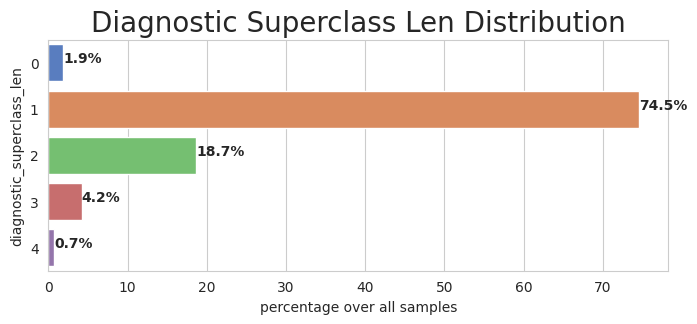

In [4]:
vc = Y['superdiagnostic_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(8,3))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnostic Superclass Len Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnostic_superclass_len")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

In [16]:
def aggregate_subclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_subclass)
    ret = list(set(tmp))
    ret = ['sub_'+r for r in ret] # to distinguish between subclass and superclass columns
    return ret

# Apply diagnostic subclass
Y['diagnostic_subclass'] = Y.scp_codes.apply(aggregate_subclass_diagnostic)
Y['diagnostic_subclass_len'] = Y['diagnostic_subclass'].apply(len)
Y.loc[Y.diagnostic_subclass_len > 1, 'diagnostic_subclass']

ecg_id
26                    [sub_STTC, sub_NST_]
28                    [sub_STTC, sub_NST_]
39           [sub_STTC, sub_NST_, sub_IMI]
45       [sub_IRBBB, sub_RVH, sub_RAO/RAE]
50                     [sub_IVCD, sub_LMI]
                       ...                
21821                [sub_IRBBB, sub_NORM]
21827                  [sub_ISCA, sub_IMI]
21828                  [sub_ISCA, sub_IMI]
21829                [sub_IRBBB, sub_NORM]
21832            [sub_IVCD, sub_LAFB/LPFB]
Name: diagnostic_subclass, Length: 6181, dtype: object

/tmp/ipykernel_27350/1108707360.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )


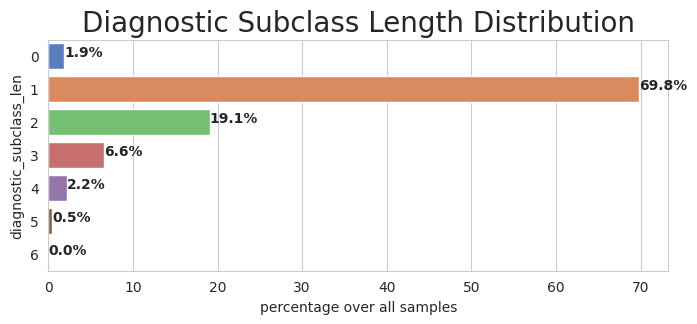

In [17]:
vc = Y['diagnostic_subclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(8,3))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnostic Subclass Length Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnostic_subclass_len")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

Reformat Data for EDA

In [16]:
all_superclass = pd.Series(np.concatenate(Y['diagnostic_superclass'].values))
all_subclass = pd.Series(np.concatenate(Y['diagnostic_subclass'].values))
superclass_cols = all_superclass.unique()
subclass_cols = all_subclass.unique()
update_cols = np.concatenate([superclass_cols, subclass_cols]) # add meta data columns
meta_cols = ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device',]

In [17]:
class ClassUpdate():
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, row):
        for sc in row['diagnostic_superclass']:
            row[sc] = 1
        for sc in row['diagnostic_subclass']:
            row[sc] = 1
            
        return row

def get_data_by_folds(folds, x, y, update_cols, feature_cols):
    assert len(folds)  > 0, '# of provided folds should longer than 1'
    #print(y.strat_fold)
    filt = np.isin(y.strat_fold.values, folds)
    x_selected = x[filt]
    y_selected = y[filt]
    
    for sc in update_cols:
        y_selected[sc] = 0
        
    cls_updt = ClassUpdate(update_cols)
    
    y_selected = y_selected.apply(cls_updt, axis=1)
    
    return x_selected, y_selected[list(feature_cols)+list(update_cols)+['strat_fold']]

In [18]:
x_all, y_all = get_data_by_folds(np.arange(1, 11), X, Y, update_cols, meta_cols)
y_all

age  sex  height  weight  nurse  site      device  NORM  MI  STTC  \
ecg_id                                                                        
1        56.0    1     NaN    63.0    2.0   0.0   CS-12   E     1   0     0   
2        19.0    0     NaN    70.0    2.0   0.0   CS-12   E     1   0     0   
3        37.0    1     NaN    69.0    2.0   0.0   CS-12   E     1   0     0   
4        24.0    0     NaN    82.0    2.0   0.0   CS-12   E     1   0     0   
5        19.0    1     NaN    70.0    2.0   0.0   CS-12   E     1   0     0   
...       ...  ...     ...     ...    ...   ...         ...   ...  ..   ...   
21833    67.0    1     NaN     NaN    1.0   2.0  AT-60    3     0   0     1   
21834   300.0    0     NaN     NaN    1.0   2.0  AT-60    3     1   0     0   
21835    59.0    1     NaN     NaN    1.0   2.0  AT-60    3     0   0     1   
21836    64.0    1     NaN     NaN    1.0   2.0  AT-60    3     1   0     0   
21837    68.0    0     NaN     NaN    1.0   2.0  AT-60    3     1   0     0   

        ...  sub_SEHYP  sub_ISCI  sub_ISC_  sub_CRBBB  sub_CLBBB  sub_LAO/LAE  \
ecg_id  ...                                                                     
1       ...          0         0         0          0          0            0   
2       ...          0         0         0          0          0            0   
3       ...          0         0         0          0          0            0   
4       ...          0         0         0          0          0            0   
5       ...          0         0         0          0          0            0   
...     ...        ...       ...       ...        ...        ...          ...   
21833   ...          0         0         0          0          0            0   
21834   ...          0         0         0          0          0            0   
21835   ...          0         0         0          0          0            0   
21836   ...          0         0         0          0          0            0   
21837   ...          0         0         0          0          0            0   

        sub_ILBBB  sub_PMI  sub_WPW  strat_fold  
ecg_id                                           
1               0        0        0           3  
2               0        0        0           2  
3               0        0        0           5  
4               0        0        0           3  
5               0        0        0           4  
...           ...      ...      ...         ...  
21833           0        0        0           7  
21834           0        0        0           4  
21835           0        0        0           2  
21836           0        0        0           8  
21837           0        0        0           9  

[21801 rows x 36 columns]

/tmp/ipykernel_31357/2111622568.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )


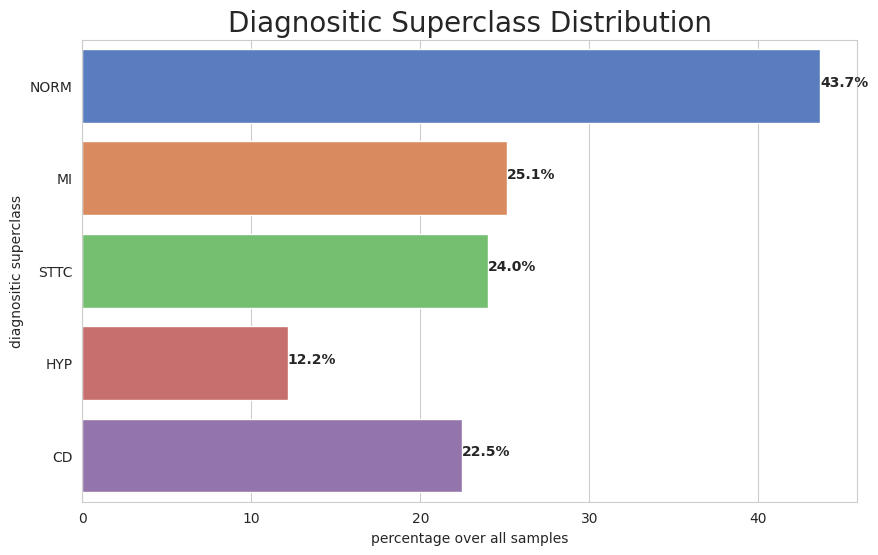

In [19]:
vc = y_all[superclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnositic Superclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic superclass")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

/tmp/ipykernel_31357/1298919675.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )


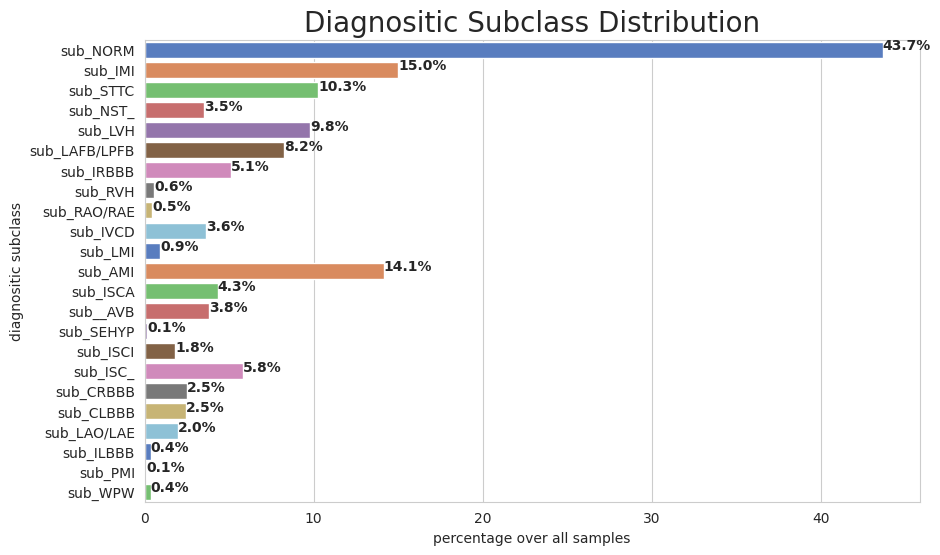

In [20]:
vc = y_all[subclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Diagnositic Subclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic subclass")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

/tmp/ipykernel_31357/493275092.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, label=superclass)
/tmp/ipykernel_31357/493275092.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, label=superclass)
/tmp/ipykernel_31357/493275092.py:6: UserWarning: 

`distplot` is a deprecated fun

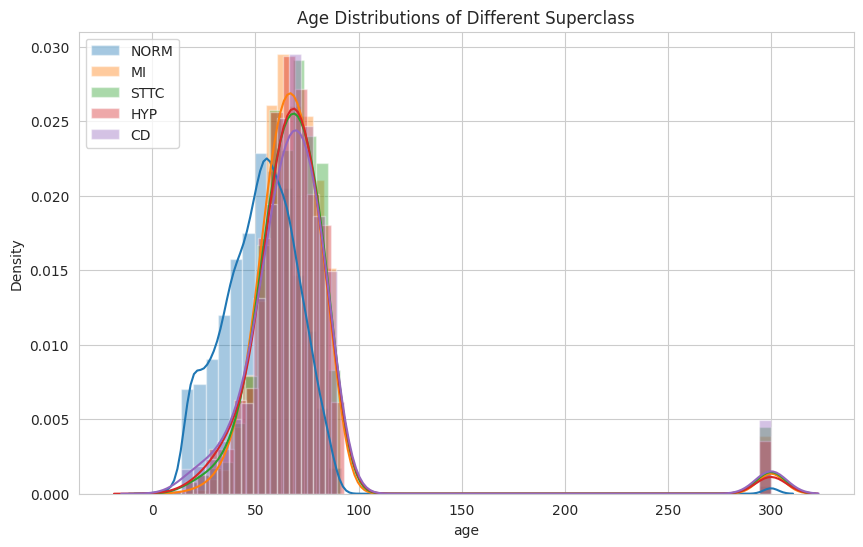

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Age Distributions of Different Superclass')

for superclass in superclass_cols:
    data = y_all.loc[y_all[superclass] == 1]['age']   
    sns.distplot(data, label=superclass)


plt.legend(loc='upper left')
plt.show()

/tmp/ipykernel_31357/1197234680.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="sex",ci=None, orient='h')


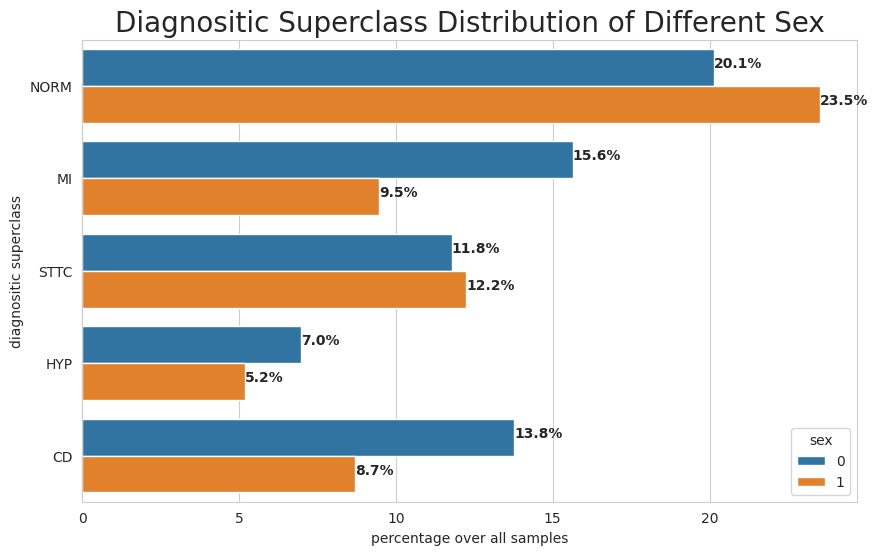

In [22]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
    
ax.set_title("Diagnositic Superclass Distribution of Different Sex", fontsize=20)

all_index, all_count, all_values = [], [], []
for sex in y_all.sex.unique():
    vc = y_all.loc[y_all.sex == sex][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [sex]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['sex'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="sex",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold')

/tmp/ipykernel_31357/2920285503.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="device",ci=None, orient='h')


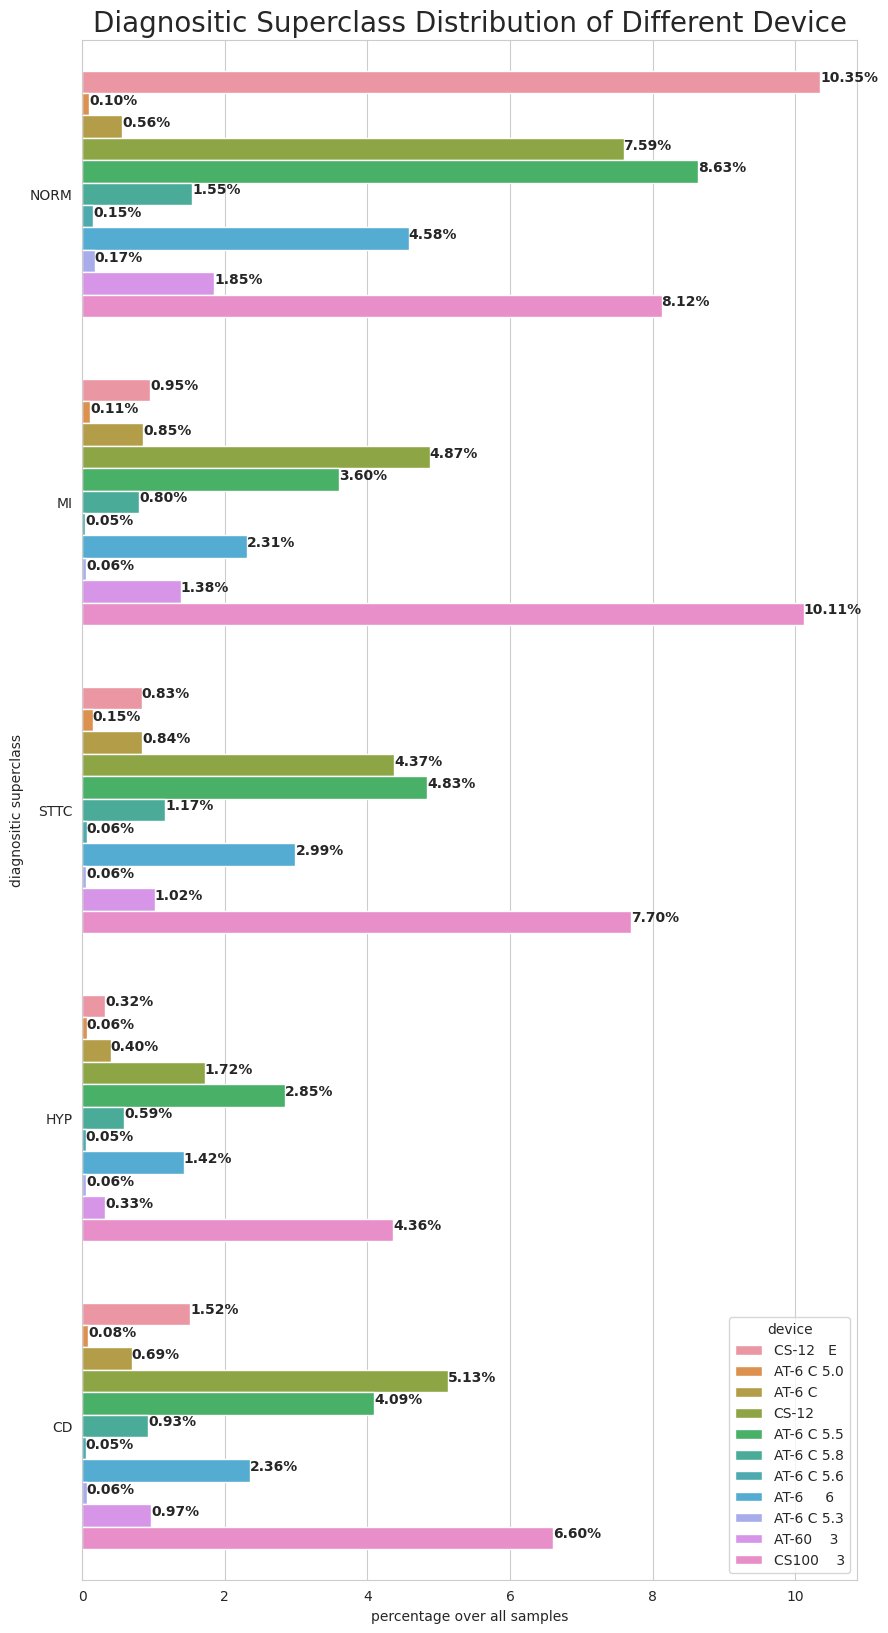

In [23]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,20))
    
ax.set_title("Diagnositic Superclass Distribution of Different Device", fontsize=20)

all_index, all_count, all_values = [], [], []
for device in y_all.device.unique():
    vc = y_all.loc[y_all.device == device][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [device]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['device'] = all_values

ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="device",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')

In [20]:
Y_data.info()
pd.DataFrame(Y_data.describe()).T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21396 entries, 1 to 21837
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21396 non-null  float64
 1   age                           21396 non-null  float64
 2   sex                           21396 non-null  int64  
 3   height                        6919 non-null   float64
 4   weight                        9367 non-null   float64
 5   nurse                         19949 non-null  float64
 6   site                          21379 non-null  float64
 7   device                        21396 non-null  object 
 8   recording_date                21396 non-null  object 
 9   report                        21396 non-null  object 
 10  scp_codes                     21396 non-null  object 
 11  heart_axis                    13228 non-null  object 
 12  infarction_stadium1           5603 non-null   object 
 13  i

count          mean          std    min      25%  \
patient_id           21396.0  11211.009067  6240.543165  302.0  5917.75   
age                  21396.0     62.610628    32.230381    2.0    50.00   
sex                  21396.0      0.480464     0.499630    0.0     0.00   
height                6919.0    166.695476    10.869468    6.0   160.00   
weight                9367.0     71.021672    15.876918    5.0    60.00   
nurse                19949.0      2.313900     3.261345    0.0     0.00   
site                 21379.0      1.559147     4.200513    0.0     0.00   
validated_by         12296.0      0.745690     1.179663    0.0     0.00   
strat_fold           21396.0      5.503505     2.875826    1.0     3.00   
superdiagnostic_len  21396.0      1.298233     0.582440    1.0     1.00   

                         50%       75%      max  
patient_id           11360.5  16568.25  21797.0  
age                     62.0     72.00    300.0  
sex                      0.0      1.00      1.0  
height                 166.0    174.00    209.0  
weight                  70.0     80.00    250.0  
nurse                    1.0      4.00     11.0  
site                     1.0      2.00     50.0  
validated_by             1.0      1.00     11.0  
strat_fold               6.0      8.00     10.0  
superdiagnostic_len      1.0      1.00      4.0

In [21]:
categorical_columns = Y_data.select_dtypes(include=['object'])
pd.DataFrame(categorical_columns.describe()).T

count unique                                    top  \
device                 21396     11                             CS100    3   
recording_date         21396  21390                    1994-02-21 14:11:13   
report                 21396   9773              sinus rhythm. normal ecg.   
scp_codes              21396   5257             {'NORM': 100.0, 'SR': 0.0}   
heart_axis             13228      8                                    MID   
infarction_stadium1     5603      6                                unknown   
infarction_stadium2      103      3                            Stadium III   
baseline_drift          1580    316                                   , V6   
static_noise            3207    124                             , I-AVR,     
burst_noise              581    100                                  alles   
electrodes_problems       28     14                                     V6   
extra_beats             1884    124                                    1ES   
pacemaker                 15      4                          ja, pacemaker   
filename_lr            21396  21396              records100/00000/00001_lr   
filename_hr            21396  21396              records500/00000/00001_hr   
r_peaks                21396  21394  [ 14 136 258 377 499 620 741 859 979]   
diagnostic_superclass  21396     22                                 [NORM]   

                       freq  
device                 5886  
recording_date            2  
report                 1734  
scp_codes              6144  
heart_axis             7625  
infarction_stadium1    3422  
infarction_stadium2      65  
baseline_drift          218  
static_noise            945  
burst_noise             130  
electrodes_problems       7  
extra_beats             403  
pacemaker                 9  
filename_lr               1  
filename_hr               1  
r_peaks                   2  
diagnostic_superclass  9072

## Missing Values

In [22]:
Y_data.isnull().sum().sort_values(ascending=False)

pacemaker                       21381
electrodes_problems             21368
infarction_stadium2             21293
burst_noise                     20815
baseline_drift                  19816
extra_beats                     19512
static_noise                    18189
infarction_stadium1             15793
height                          14477
weight                          12029
validated_by                     9100
heart_axis                       8168
nurse                            1447
site                               17
S12-LVH                             0
Q-ISC-QPeak                         0
Q-ISC                               0
ST-DEPR-MI                          0
STRAIN                              0
MI-ALL                              0
Q-ISC-V2V3                          0
Q-ISC-RPeak                         0
ST-ELEV-MI                          0
diagnostic_superclass               0
QRS-CLBB                            0
SLI-LVH                             0
LI-LVH      

<AxesSubplot: >

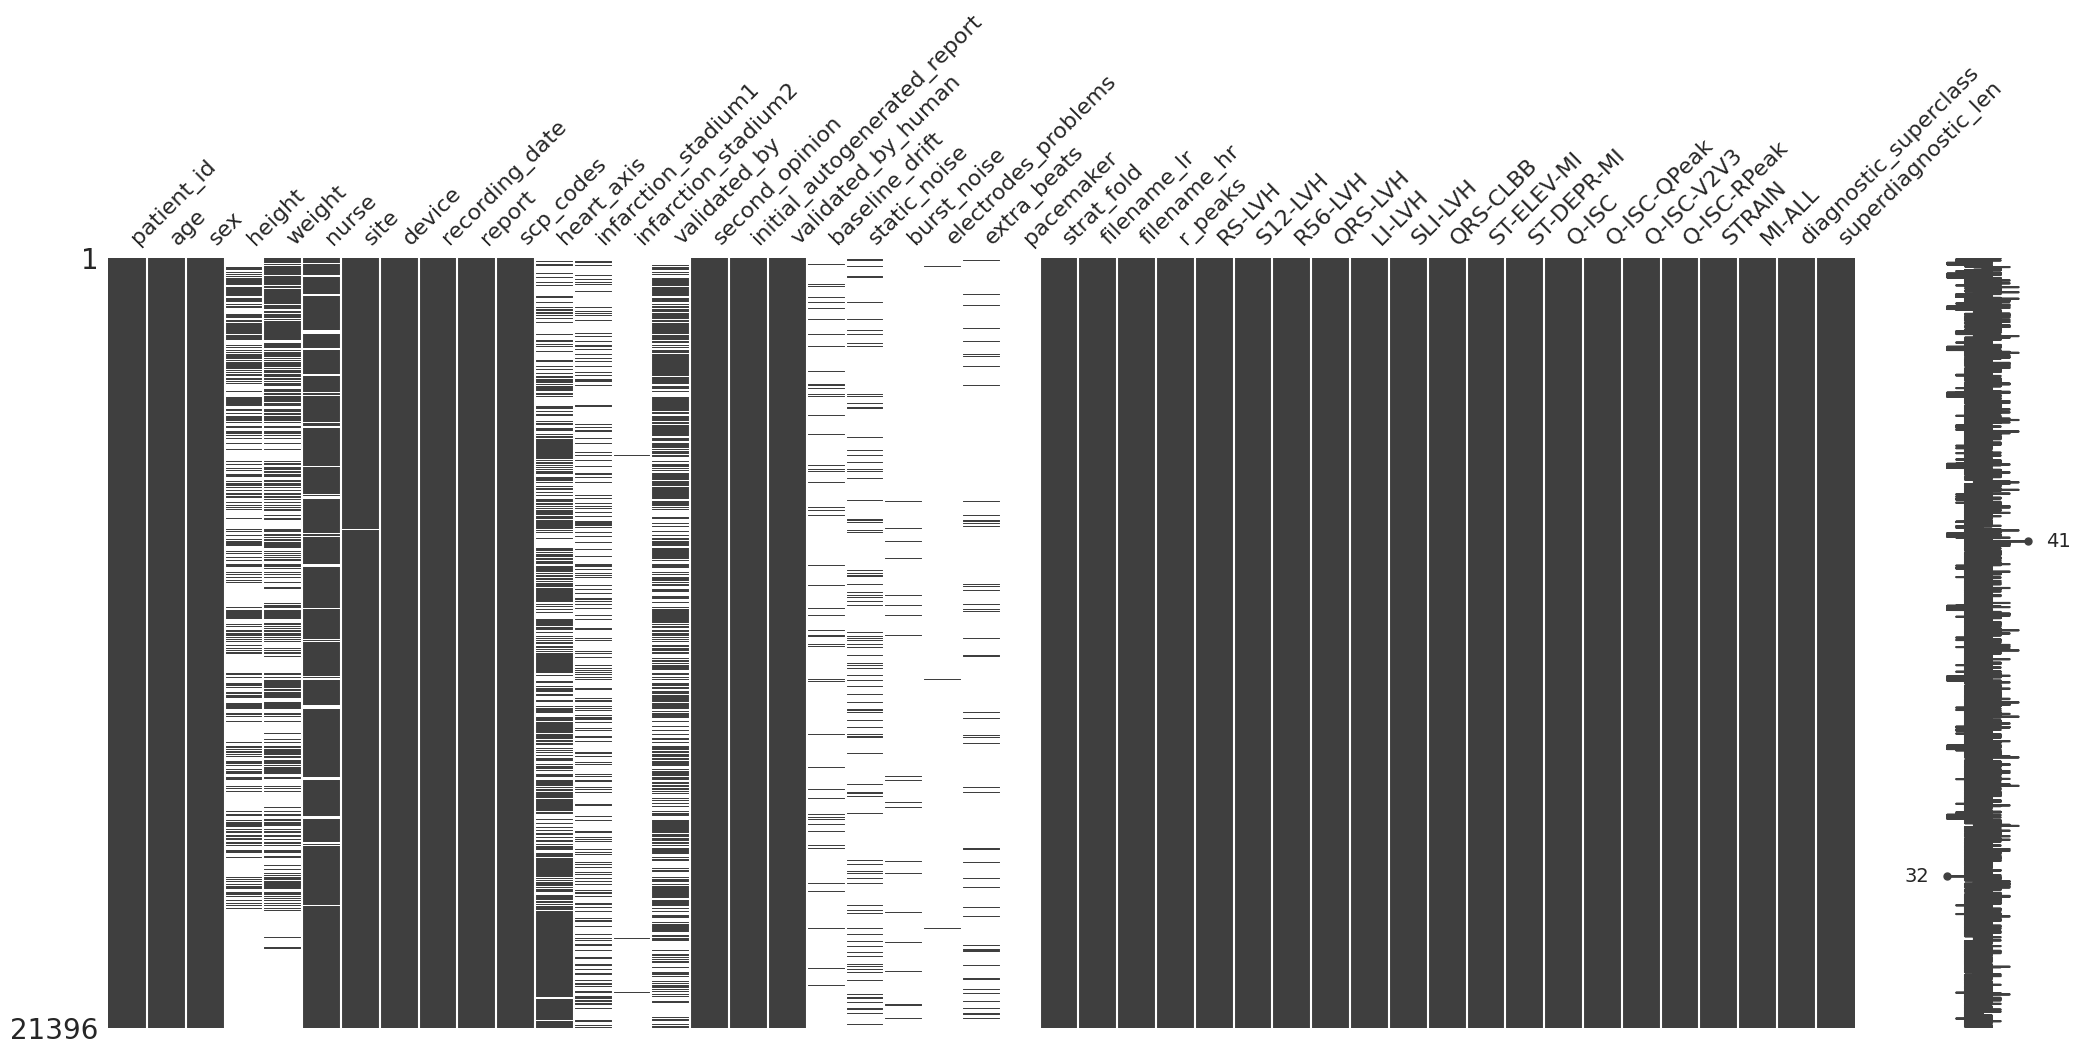

In [23]:
msno.matrix(Y_data)

## Feature extraction

---

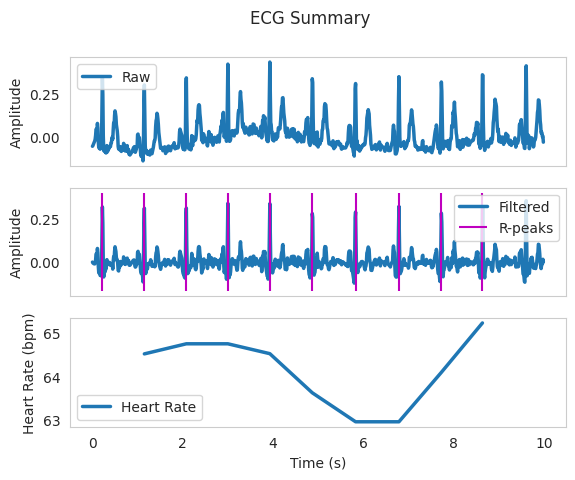

In [5]:
lead = 1
out = ecg.ecg(signal=X_data[0, :, lead], sampling_rate=100., show=True)

In [22]:
lead = 1
[ts, fts, rpeaks, tts, thb, hrts, hr] = ecg.ecg(signal=X_data[0, :, lead], sampling_rate=100, show=False)
"""
    Returns:	

    ts (array) – Signal time axis reference (seconds).
    filtered (array) – Filtered ECG signal.
    rpeaks (array) – R-peak location indices. 
    templates_ts (array) – Templates time axis reference (seconds).
    templates (array) – Extracted heartbeat templates.
    heart_rate_ts (array) – Heart rate time axis reference (seconds).
    heart_rate (array) – Instantaneous heart rate (bpm).
"""

'\n    Returns:\t\n\n    ts (array) – Signal time axis reference (seconds).\n    filtered (array) – Filtered ECG signal.\n    rpeaks (array) – R-peak location indices.\n    templates_ts (array) – Templates time axis reference (seconds).\n    templates (array) – Extracted heartbeat templates.\n    heart_rate_ts (array) – Heart rate time axis reference (seconds).\n    heart_rate (array) – Instantaneous heart rate (bpm).\n'

In [23]:
def average_heart_beat(rpeaks, sampling_rate):
    heart_beats = len(rpeaks)
    total_time = len(X_data[0, :, lead])/sampling_rate
    average_heart_beat = heart_beats/total_time*60
    return average_heart_beat

average_heart_beat = average_heart_beat(rpeaks, 100)
total_heart_beats = len(rpeaks)
print(f"Average heart beat = {average_heart_beat} bpm")

Average heart beat = 60.0 bpm


### Compare processed  rpeaks of signals with ground truth 

In [41]:
sample_id = 5
lead = 1
[ts, fts, rpeaks, tts, thb, hrts, hr] = ecg.ecg(signal=X_data[sample_id, :, lead], sampling_rate=100, show=False)

print(f"Processed Rpeaks: {rpeaks} \n True Rpeaks:     {Y_data['r_peaks'].iloc[sample_id]} ")

Processed Rpeaks: [ 64 130 199 271 346 422 496 572 642 709 779 853 930] 
 True Rpeaks:     [ 64 130 199 270 346 422 496 572 642 709 779 853 930] 


In [43]:
# Calculate HRV
rr_intervals = np.diff(rpeaks)
hrv_signal = np.array(rr_intervals)

hrv_signal

array([66, 69, 72, 75, 76, 74, 76, 70, 67, 70, 74, 77])

## Feature Extractor

In [3]:
from features import feature_extractor

In [9]:
sample_id = 5
lead_id = 1
ecg_sample = X_data[sample_id, :, lead_id]
sample_ecg_features = feature_extractor.get_features_dict(ecg_sample)

In [43]:
sample_ecg_features

{'hr_max': 89.59156785243741,
 'hr_min': 78.97507897507899,
 'hr_mean': 83.34656109520346,
 'hr_median': 82.67209838148054,
 'hr_mode': 0,
 'hr_std': 3.2690032544435623,
 'PR_interval': 15,
 'P_max': 0.11964525951176525,
 'P_to_R': 0.11531346246947005,
 'P_to_Q': 0.3072684454103422,
 'ST_interval': 18,
 'T_max': 0.04374619056924871,
 'R_plus': 1.0,
 'R_minus': 0.0,
 'T_to_R': 0.04216234496021379,
 'T_to_S': 0.46569539963722917,
 'P_to_T': 2.734986931544838,
 'P_skew': 0.0692977888856174,
 'P_kurt': -1.312198165465743,
 'T_skew': 0.09079301497114943,
 'T_kurt': -0.9906999641590728,
 'activity': 0.03108992201184715,
 'mobility': 0.9695399108023557,
 'complexity': 1.301128634778211,
 'QRS_len': 6,
 'QRS_diff': 0.18083022506537708,
 'QS_diff': 0.23432602316940349,
 'QRS_kurt': -0.6714086411458191,
 'QRS_skew': 0.8023473001398336,
 'QRS_minmax': 0.8499422201652819,
 'P_std': 0.011485822295776943,
 'T_std': 0.010218364045501964,
 'pft0': 0.06397879702773837,
 'pft1': -0.46617821132876436,
 '

## RMSSD

In [44]:
import numpy as np

def mean_RMSSD(rr_intervals):
  """
  Calculates the mean root mean square of successive differences (RMSSD) of the RR intervals.

  Parameters:
    rr_intervals (array): Array of RR intervals in seconds.

  Returns:
    mean_rmssd (float): The mean RMSSD of the RR intervals.
  """
  # Calculate the difference between successive RR intervals
  rmssd = np.diff(rr_intervals)
  
  # Square the differences
  rmssd = np.square(rmssd)
  
  # Calculate the root mean square of the differences
  rmssd = np.sqrt(np.mean(rmssd))
  
  return rmssd


In [45]:
rmssd = mean_RMSSD(rr_intervals)
rmssd

3.2333489534143163

## HRV Signal

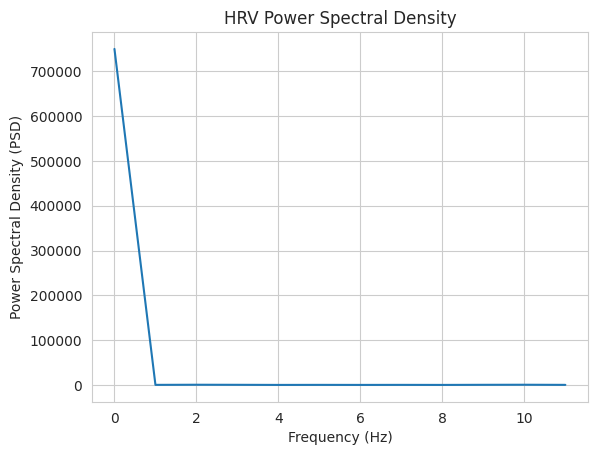

In [46]:
# Calculate FFT of HRV signal
fft_hrv = np.fft.fft(hrv_signal)

# Calculate power spectral density (PSD) of HRV
psd_hrv = np.abs(fft_hrv)**2

# Plot HRV PSD
plt.plot(psd_hrv)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (PSD)")
plt.title("HRV Power Spectral Density")
plt.show()


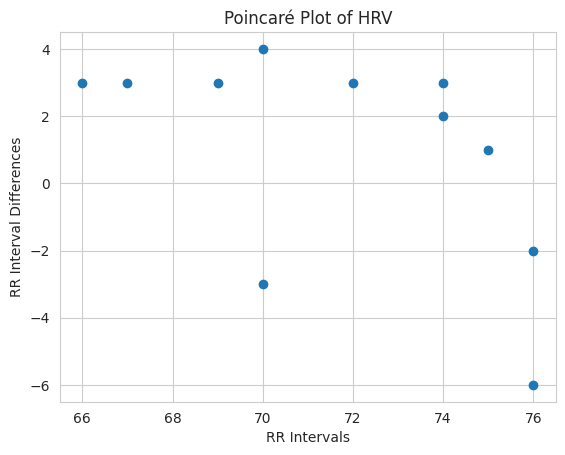

In [47]:
from scipy.spatial import distance

# Calculate the difference between consecutive RR intervals
diff_rr = np.diff(rr_intervals)

# Plot Poincaré Plot of HRV
plt.scatter(rr_intervals[:-1], diff_rr)
plt.xlabel("RR Intervals")
plt.ylabel("RR Interval Differences")
plt.title("Poincaré Plot of HRV")
plt.show()

# Calculate sample entropy of HRV
# sample_entropy = distance.sampen(rr_intervals)


# QRSDtector

In [44]:
def plot_signal(signal):
  plt.figure(figsize=(36, 6))
  plt.plot(signal)
  plt.xlabel('Time (ms)')
  plt.ylabel('Amplitude (mV)')
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)


def plot_ecg_1_lead(ecg_data, sample_id: int, lead_id: int):
  signal = X_data[sample_id, :, lead_id]
  plot_signal(signal)
  plt.show()
  # plt.savefig("Pacemaker ecg.png")

def plot_QRS_complex(signal):
  # Plot ECG signal and annotate the QRS complex
  out = ecg.ecg(signal=signal, sampling_rate=100, show=False)
  rpeaks = out['rpeaks']
  
  plot_signal(signal)

  for rpeak in rpeaks:
      plt.axvline(rpeak, color='red', label='QRS Complex')

  # plt.legend()
  plt.show()


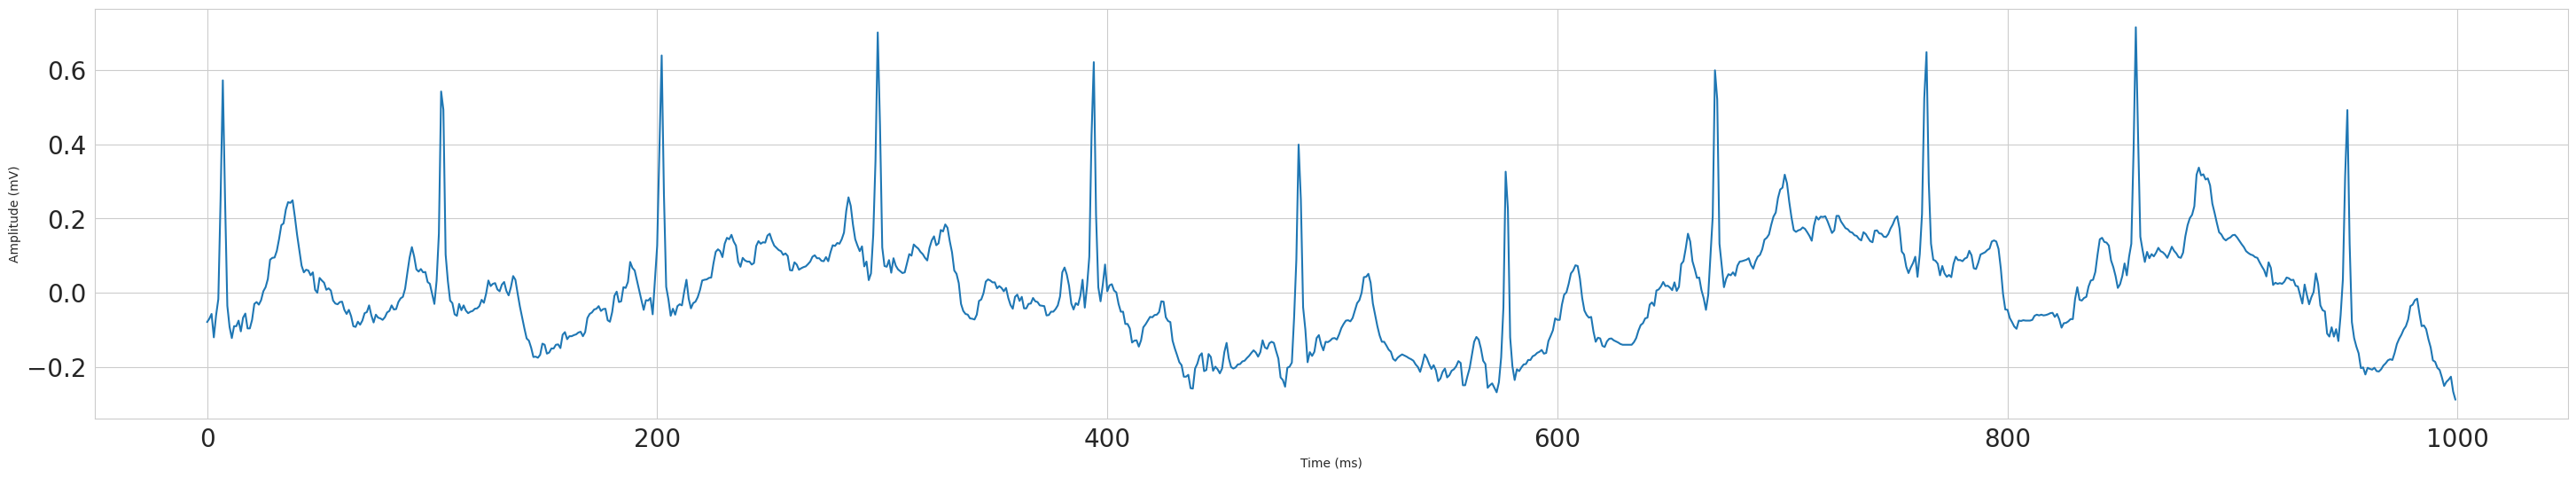

In [45]:
plot_ecg_1_lead(X_data, sample_id=2, lead_id=1)

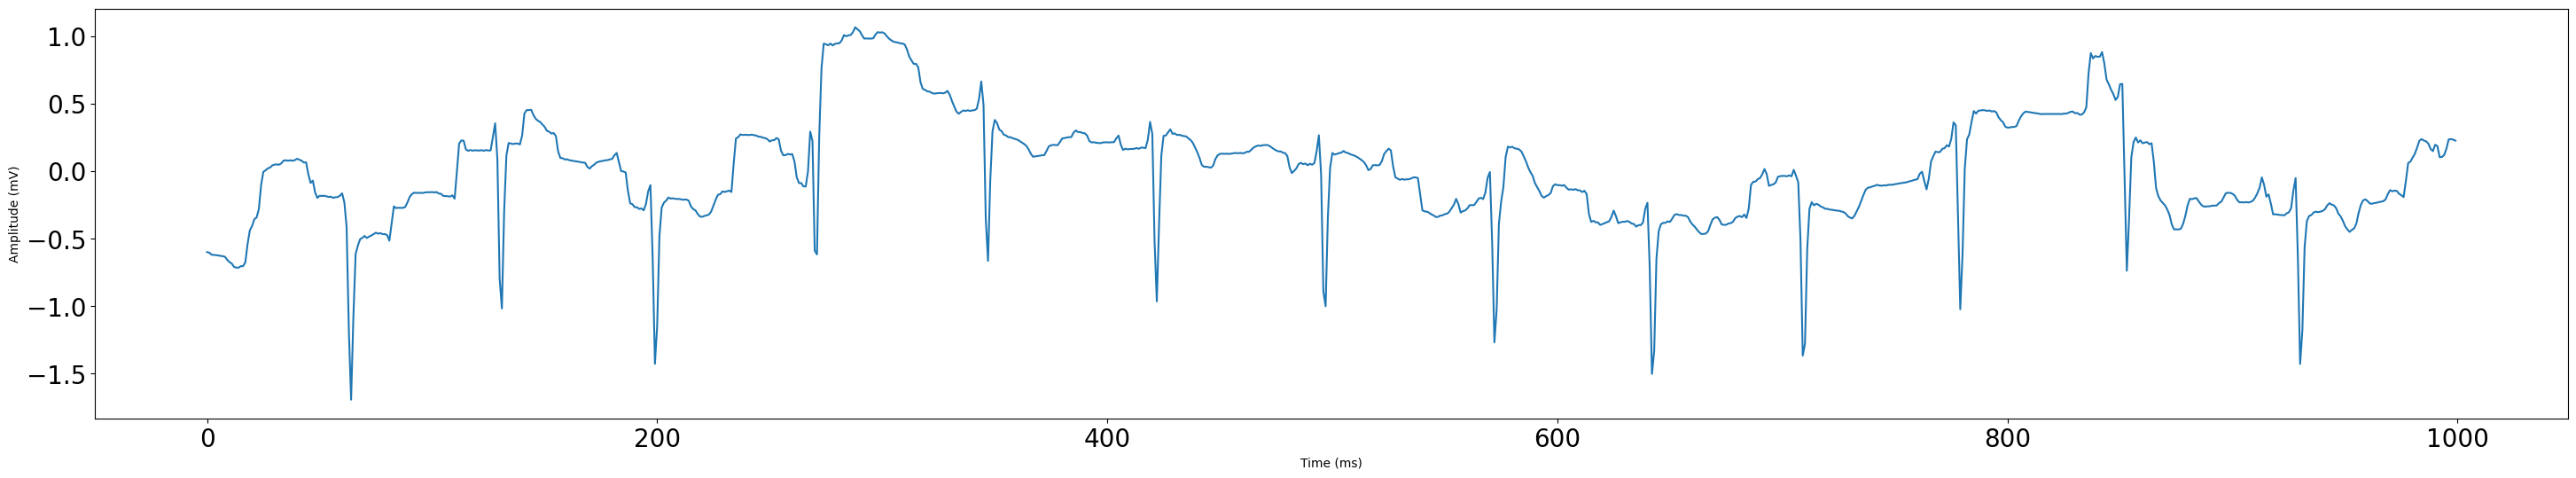

In [17]:
plot_ecg_1_lead(X_data, sample_id=5, lead_id=6)

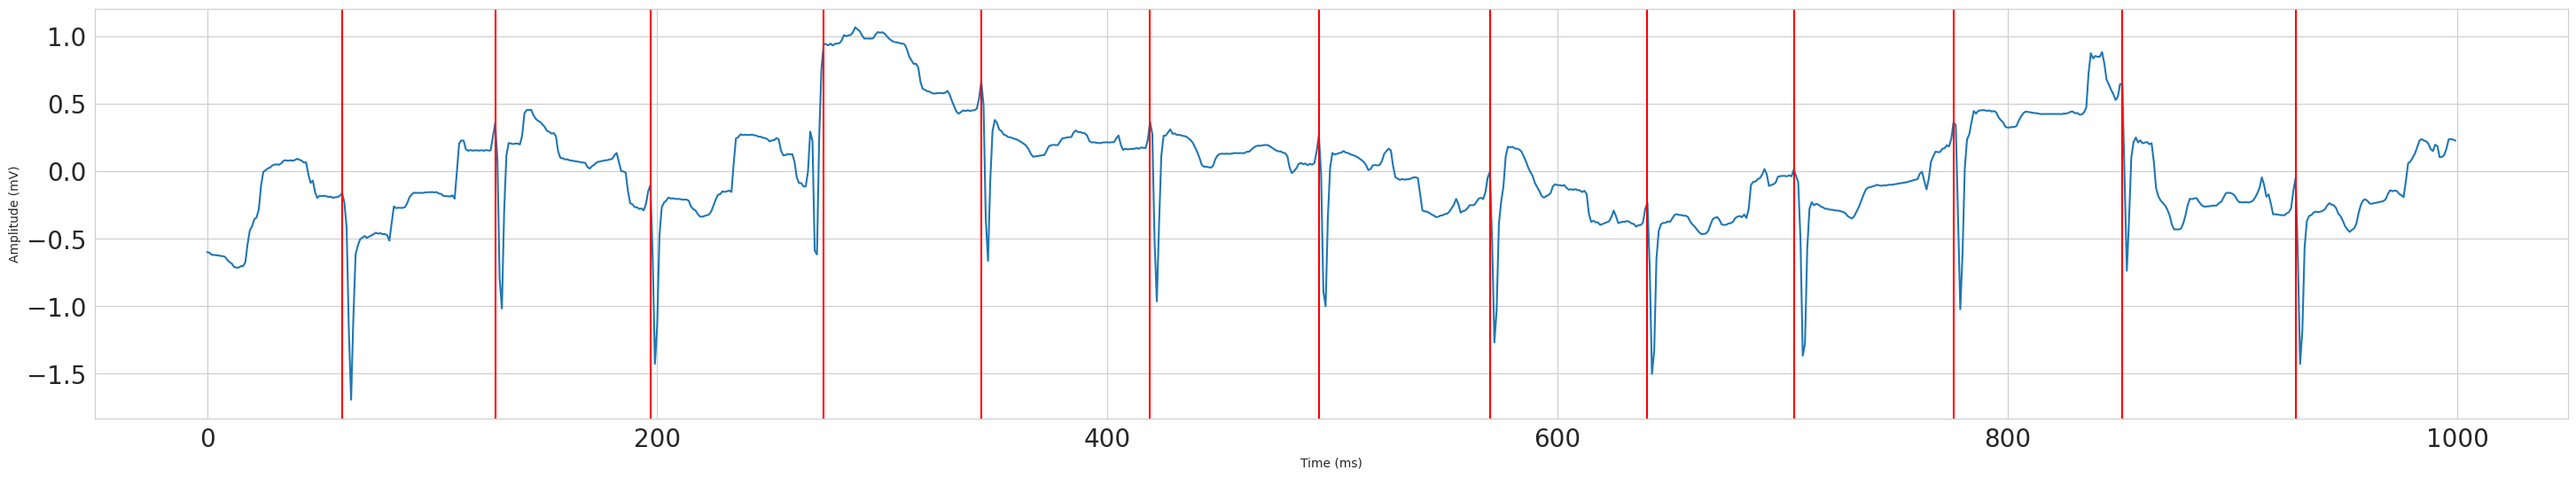

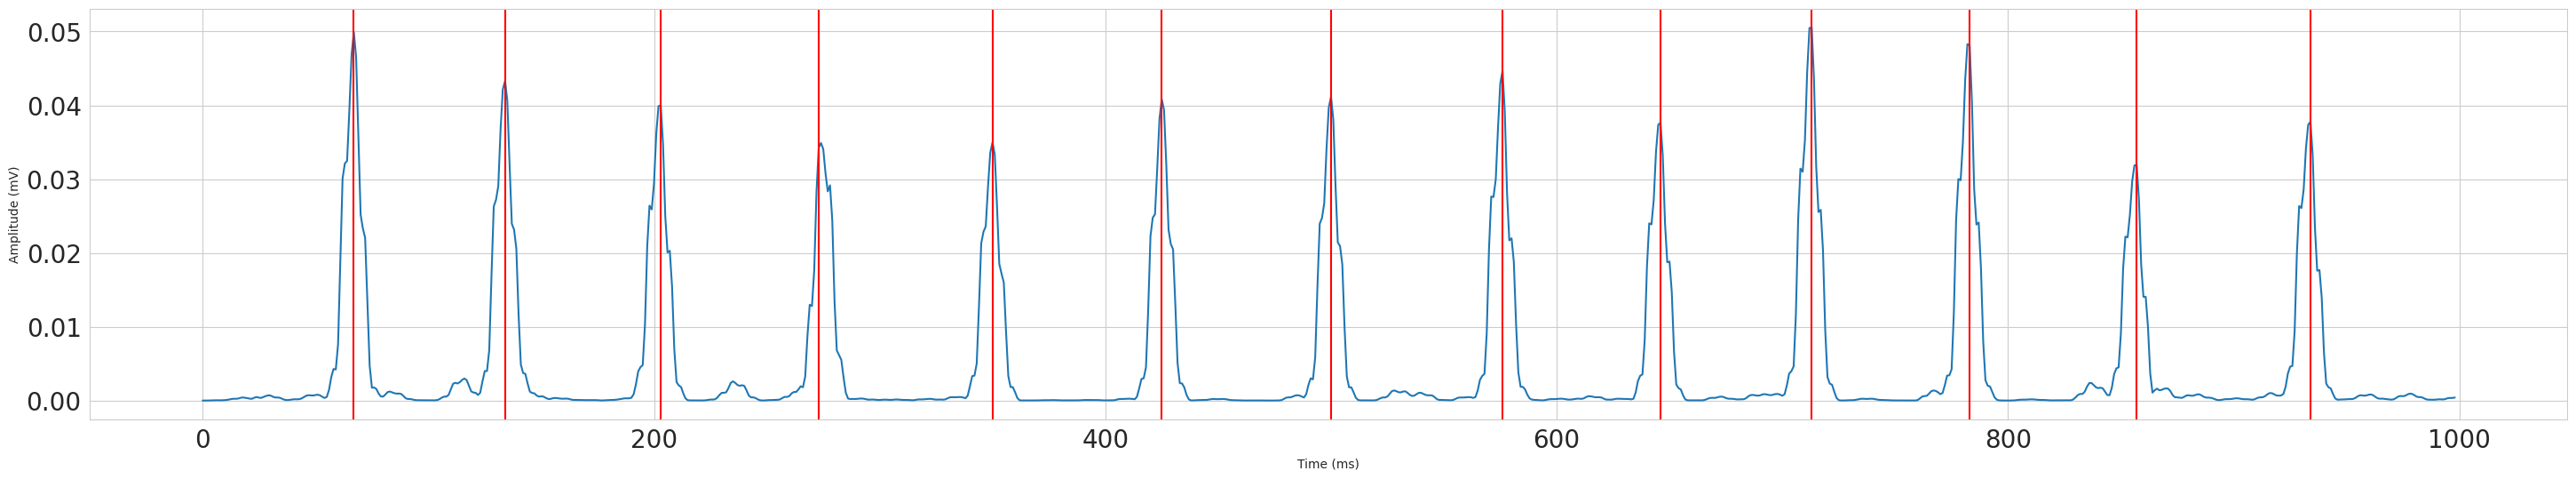

In [262]:
sample_id, lead_id = (5, 6)
no_filtered_signal = X_data[sample_id, :, lead_id]
plot_QRS_complex(no_filtered_signal)

filtered_signal = Pan_tompkins(no_filtered_signal, 100).fit()
plot_QRS_complex(filtered_signal)

# Comparing ECGs 

### Fourier transform

In [10]:
def plot_fourier_signal(signal):
  plt.figure(figsize=(36, 6))
  plt.plot(signal)
  plt.xlabel('Frequency')
  plt.ylabel('Magnitude')
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

# Define function for fourier transform
def fourier_transform(ecg, fs, length):
    T = 1.0 / fs
    N = length
    
    yf = np.fft.fft(ecg)
    xf = np.fft.fftfreq(N,T)[:N//2]

    fft_res = 2.0/N * np.abs(yf[0:N//2])
    return fft_res #[:np.where(xf >= 100)[0][0]]

In [11]:
def get_data_subset(X_data, Y_data, class_label):
    # Create a boolean mask where the diagnostic_superclass column contains the class label
    mask = Y_data['diagnostic_superclass'].apply(lambda x: [class_label] == x)
    # Subset the data based on the boolean mask
    subset = X_data[mask]
    return subset

def get_pacemaker_subset(X_data, Y_data):
    mask = Y_data['pacemaker'].apply(lambda x: "pacemaker" in str(x))
    subset = X_data[mask]
    return subset


In [12]:
# Call the function for each class label
ecg_sttc = get_data_subset(X_data, Y_data, 'STTC')
ecg_norm = get_data_subset(X_data, Y_data, 'NORM')
ecg_mi = get_data_subset(X_data, Y_data, 'MI')
ecg_hyp = get_data_subset(X_data, Y_data, 'HYP')
ecg_cd = get_data_subset(X_data, Y_data, 'CD')
# ecg_pace = get_pacemaker_subset(X_data, Y_data)
ecg_pace = X_data[1641] # Manually select a normal pacemaker ecg based on the dataset notes

Obtain signal on time and frequency domain

In [13]:
fs = 100
sample_id, lead_id = (5, 1)

lead_II_norm = ecg_norm[sample_id, :, lead_id]
fourier_ecg_norm = fourier_transform(lead_II_norm, fs, len(lead_II_norm))

lead_II_mi = ecg_mi[sample_id, :, lead_id]
fourier_ecg_mi = fourier_transform(lead_II_mi, fs, len(lead_II_mi))

lead_II_sttc = ecg_sttc[sample_id, :, lead_id]
fourier_ecg_sttc = fourier_transform(lead_II_sttc, fs, len(lead_II_sttc))

lead_II_hyp = ecg_hyp[sample_id, :, lead_id]
fourier_ecg_hyp = fourier_transform(lead_II_hyp, fs, len(lead_II_hyp))

lead_II_cd = ecg_cd[sample_id, :, lead_id]
fourier_ecg_cd = fourier_transform(lead_II_cd, fs, len(lead_II_cd))

lead_II_pace = ecg_pace[ :, lead_id]
fourier_ecg_pace = fourier_transform(lead_II_pace, fs, len(lead_II_pace))


Plot

/tmp/ipykernel_32105/2123583224.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


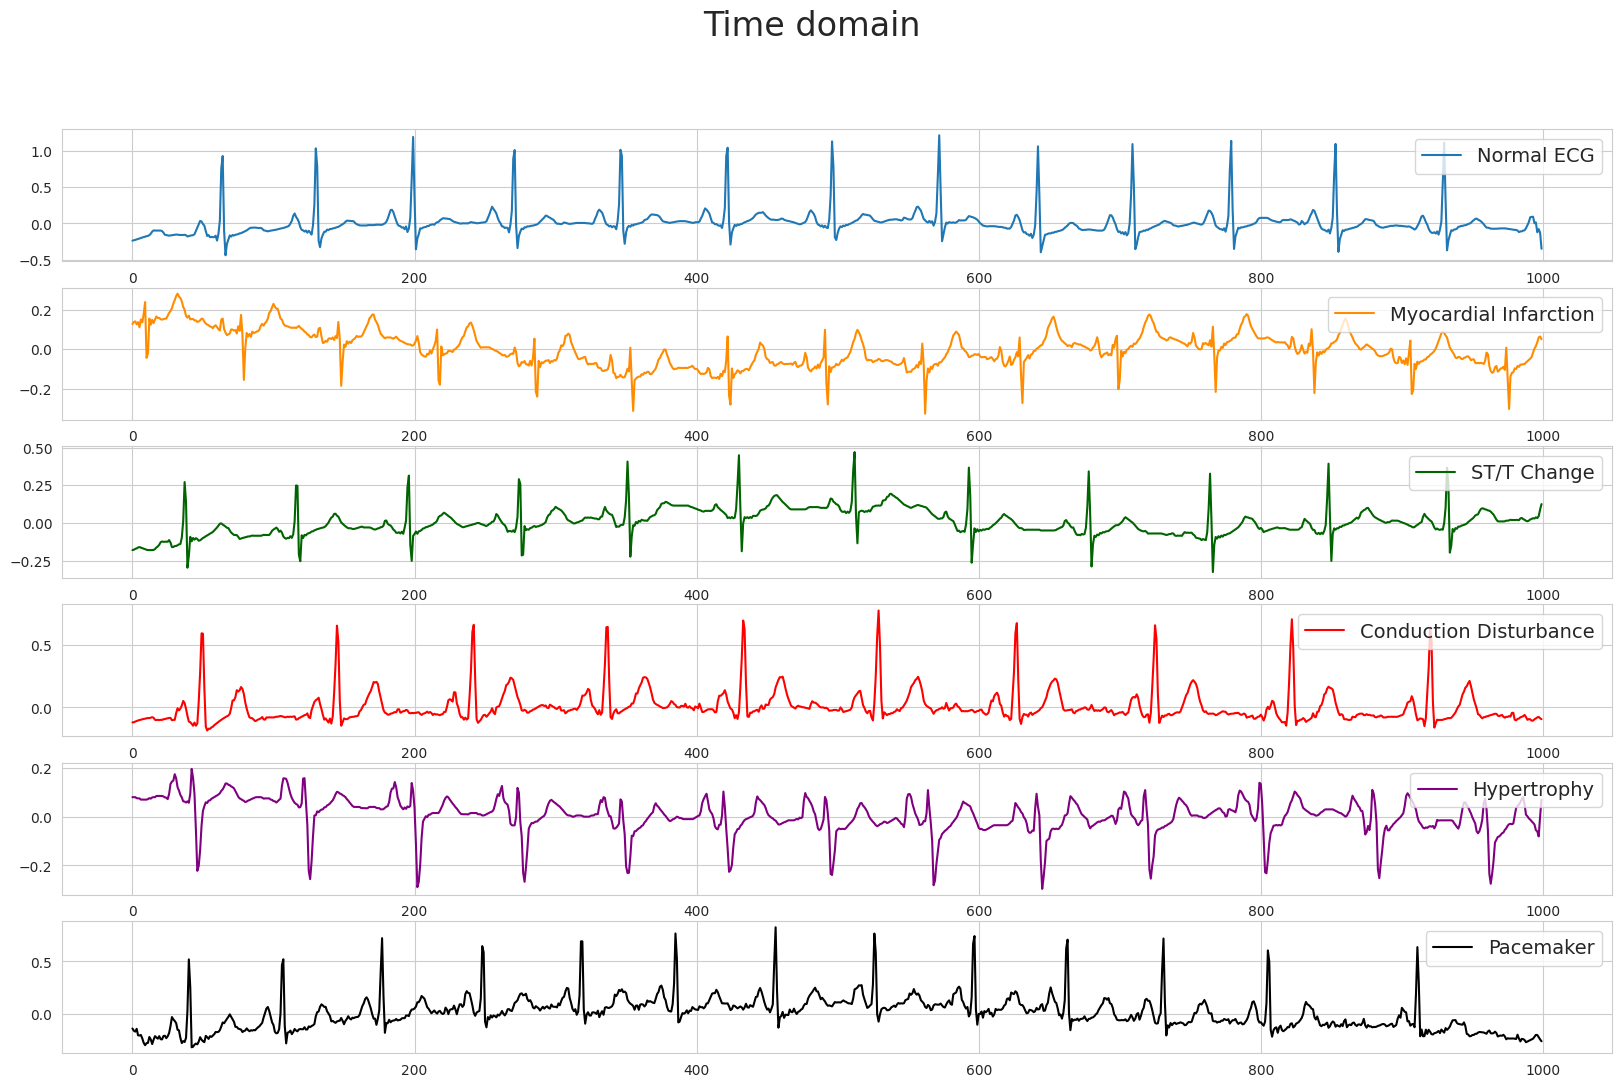

In [89]:
fig, ax = plt.subplots(6, 1, figsize=(20, 12))
fig.suptitle('Time domain', fontsize=24)

ax[0].plot(lead_II_norm, label="Normal ECG")
ax[1].plot(lead_II_mi,label="Myocardial Infarction", color="darkorange")
ax[2].plot(lead_II_sttc, label="ST/T Change", color="darkgreen")
ax[3].plot(lead_II_cd, label="Conduction Disturbance", color="red")
ax[4].plot(lead_II_hyp, label="Hypertrophy", color="purple")
ax[5].plot(lead_II_pace, label="Pacemaker", color="black")

ax[0].legend(loc='upper right',fontsize=14)
ax[1].legend(loc='upper right',fontsize=14)
ax[2].legend(loc='upper right',fontsize=14)
ax[3].legend(loc='upper right',fontsize=14)
ax[4].legend(loc='upper right',fontsize=14)
ax[5].legend(loc='upper right',fontsize=14)

fig.savefig("all_time_domain.png", dpi=500)
fig.show()


/tmp/ipykernel_32105/1797003705.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


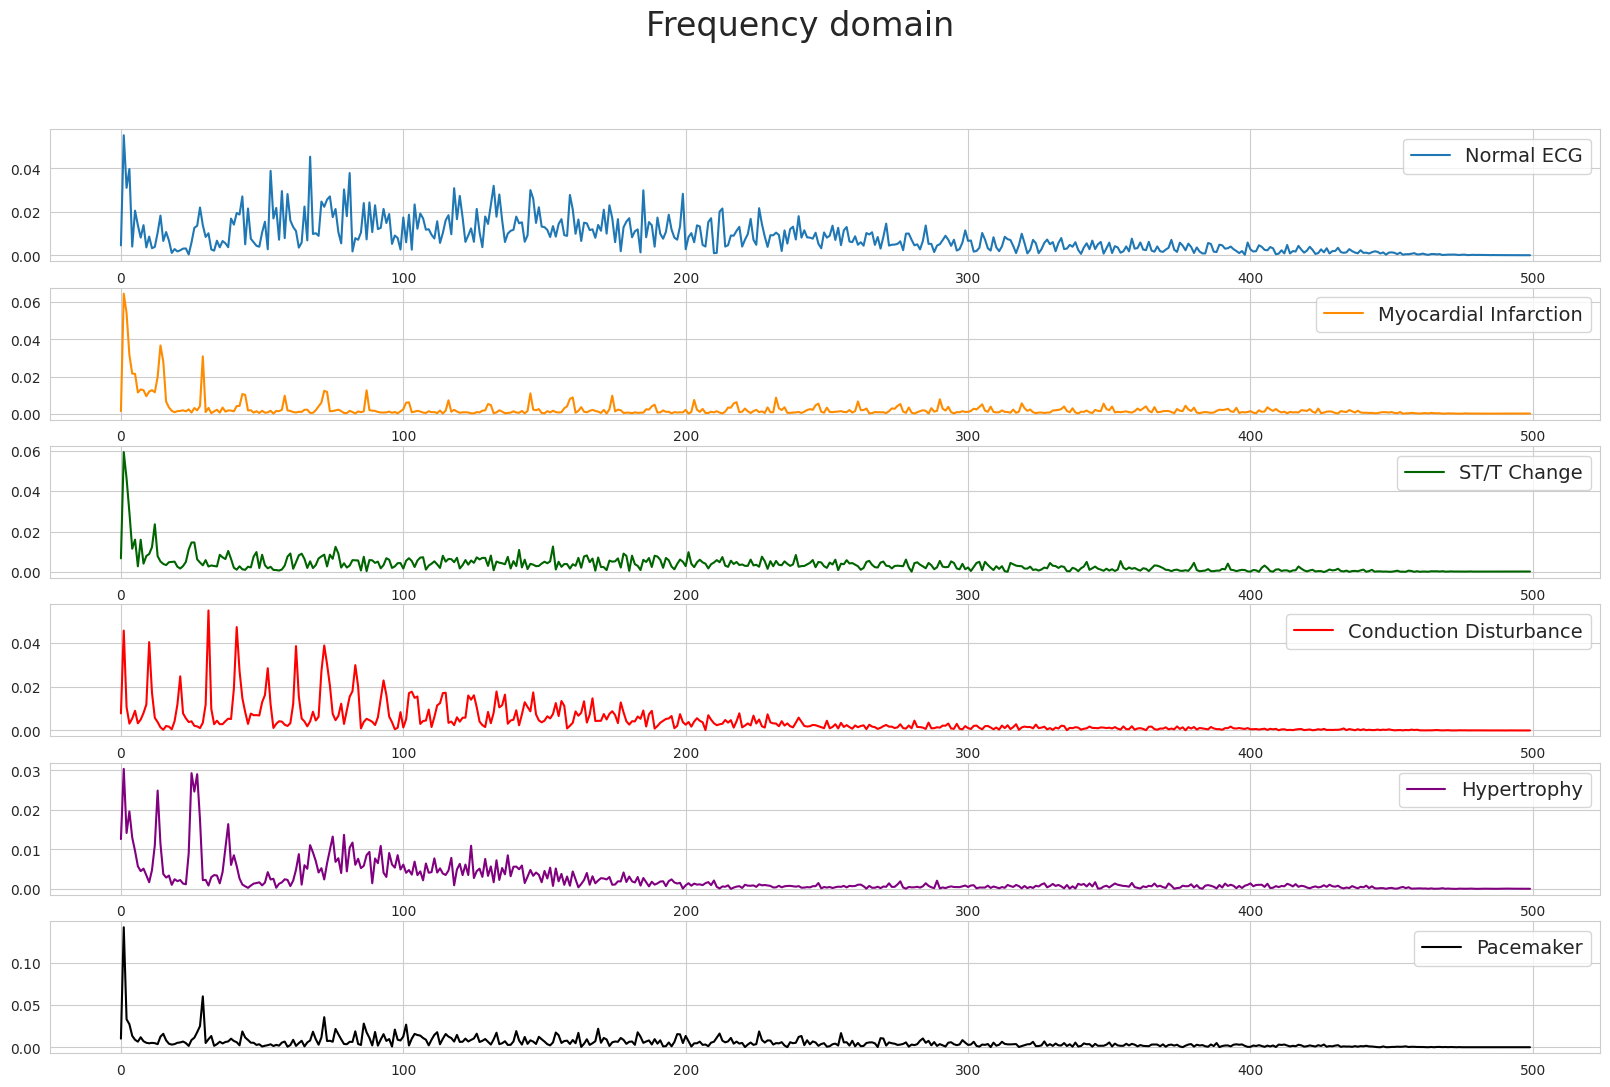

In [90]:
fig, ax = plt.subplots(6, 1, figsize=(20, 12))
fig.suptitle('Frequency domain', fontsize=24)

ax[0].plot(fourier_ecg_norm, label="Normal ECG")
ax[1].plot(fourier_ecg_mi,label="Myocardial Infarction", color="darkorange")
ax[2].plot(fourier_ecg_sttc, label="ST/T Change", color="darkgreen")
ax[3].plot(fourier_ecg_cd, label="Conduction Disturbance", color="red")
ax[4].plot(fourier_ecg_hyp, label="Hypertrophy", color="purple")
ax[5].plot(fourier_ecg_pace, label="Pacemaker", color="black")

ax[0].legend(loc='upper right',fontsize=14)
ax[1].legend(loc='upper right',fontsize=14)
ax[2].legend(loc='upper right',fontsize=14)
ax[3].legend(loc='upper right',fontsize=14)
ax[4].legend(loc='upper right',fontsize=14)
ax[5].legend(loc='upper right',fontsize=14)

fig.savefig("all_frquency_domain.png", dpi=500)
fig.show()


# Visualize beautiful ECG

In [14]:
def plot_ecg_12_lead(signal, title):
  ecg_data = np.transpose(signal)
  ecg_plot.plot(ecg_data, sample_rate=100, title=title)
  ecg_plot.show()

In [ ]:
# Call the function for each class label
ecg_sttc = get_data_subset(X_data, Y_data, 'STTC')
ecg_norm = get_data_subset(X_data, Y_data, 'NORM')
ecg_mi = get_data_subset(X_data, Y_data, 'MI')
ecg_hyp = get_data_subset(X_data, Y_data, 'HYP')
ecg_cd = get_data_subset(X_data, Y_data, 'CD')
# ecg_pace = get_pacemaker_subset(X_data, Y_data)
ecg_pace = X_data[1641] # Manually select a normal pacemaker ecg based on the dataset notes

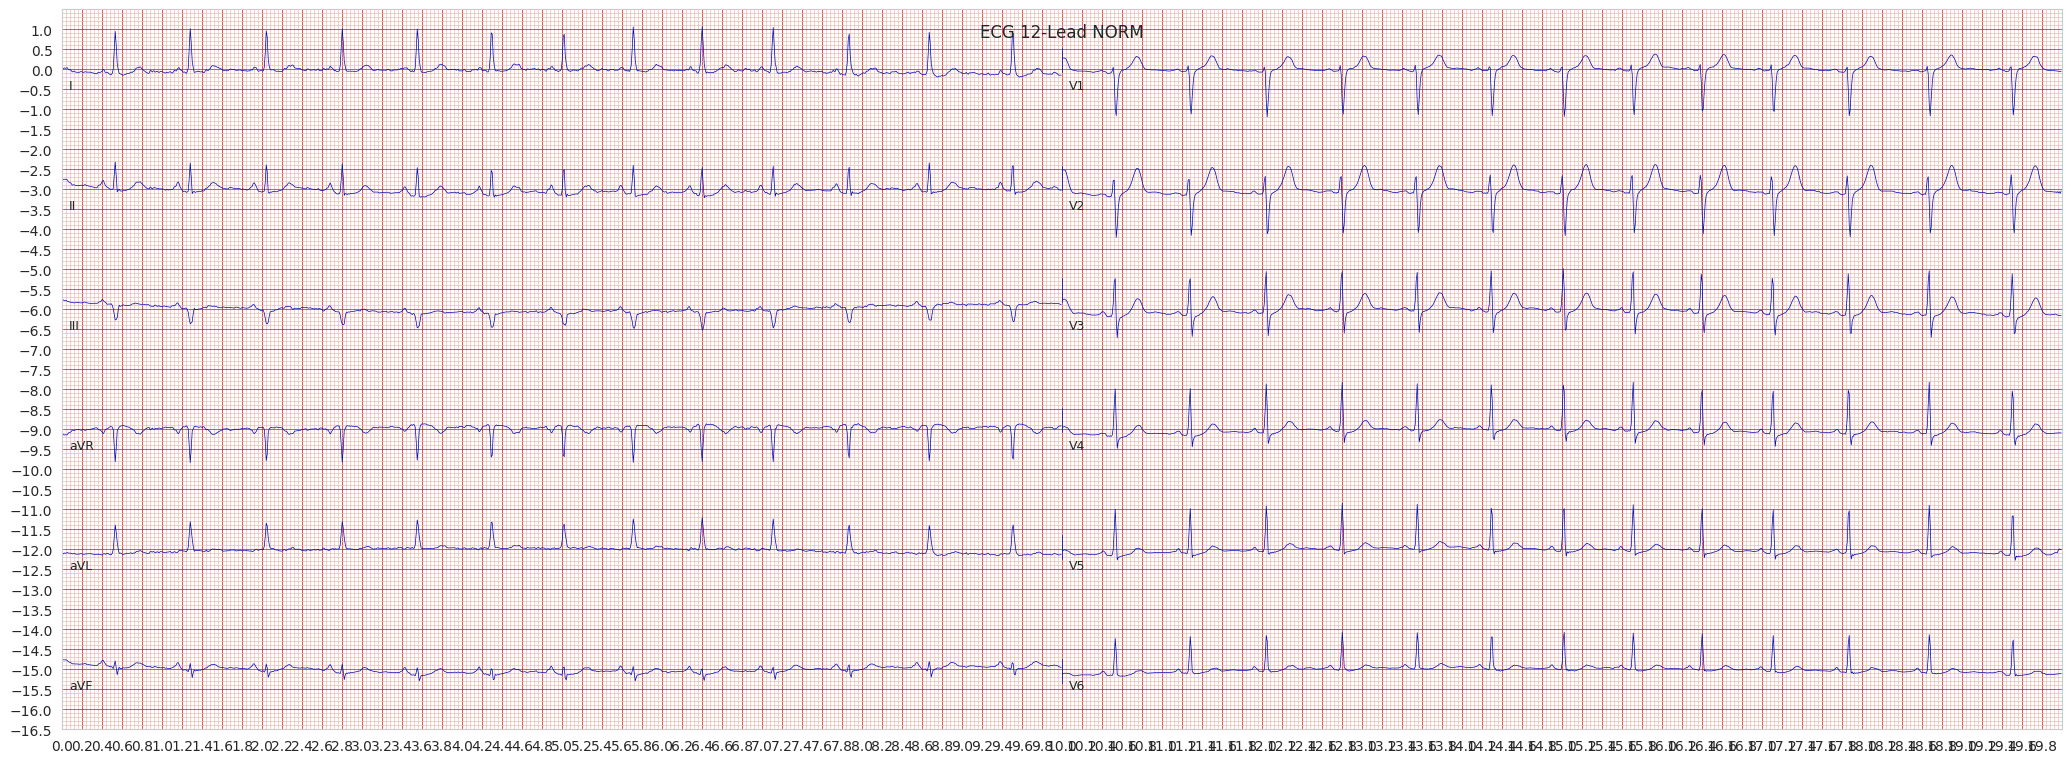

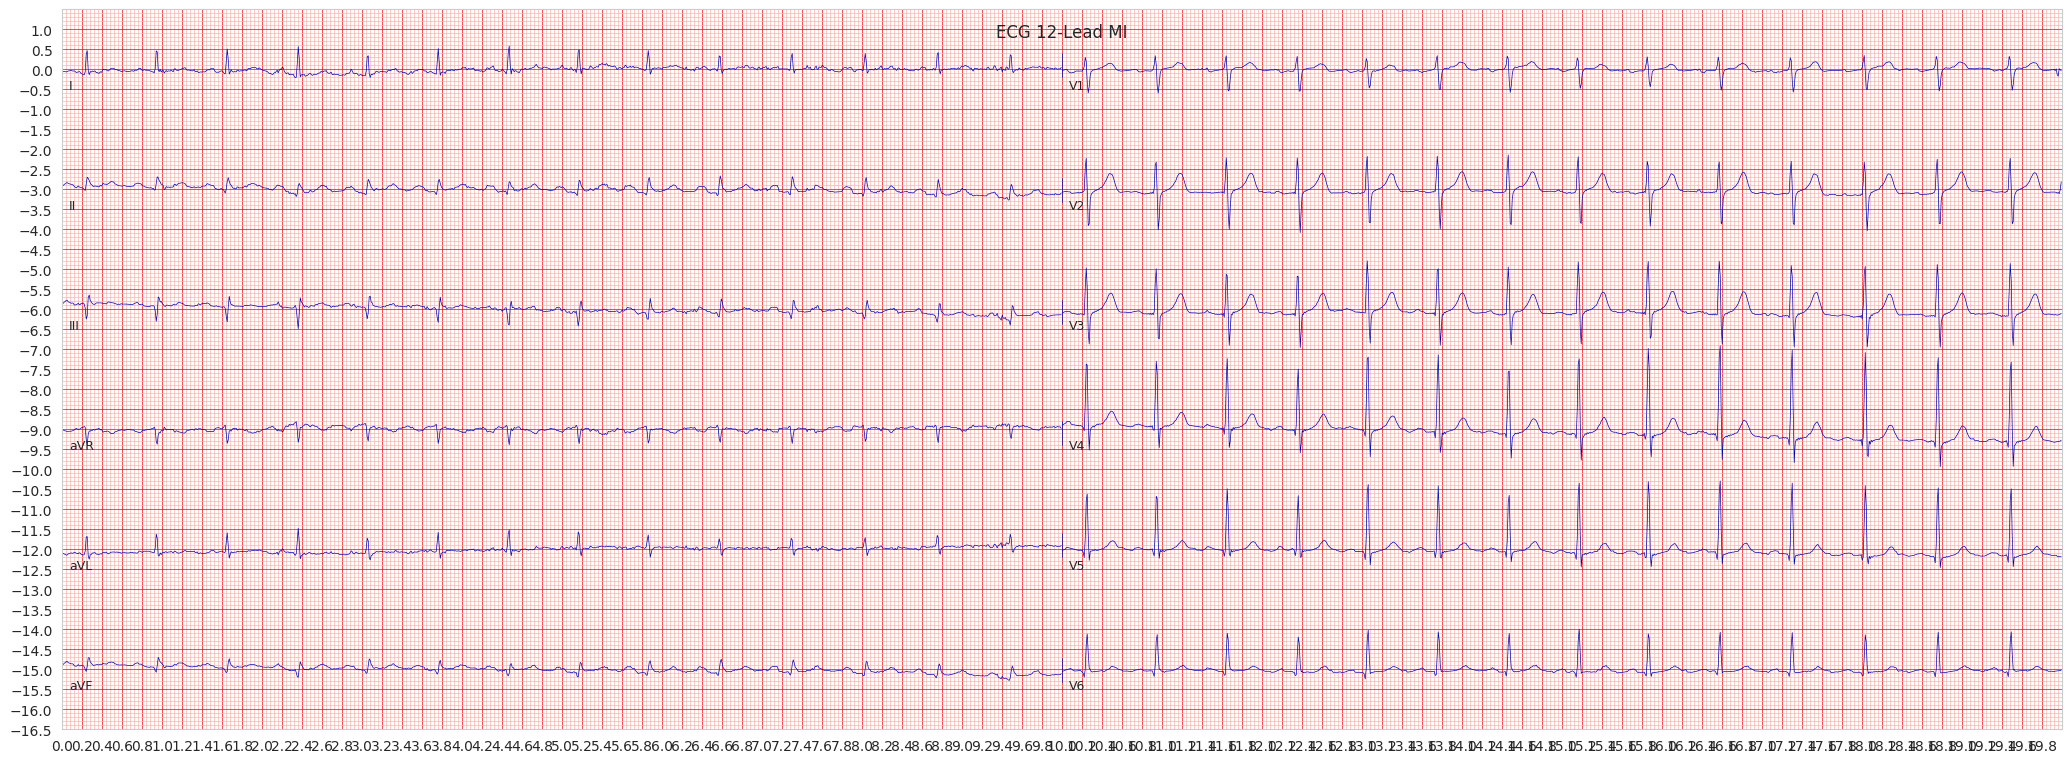

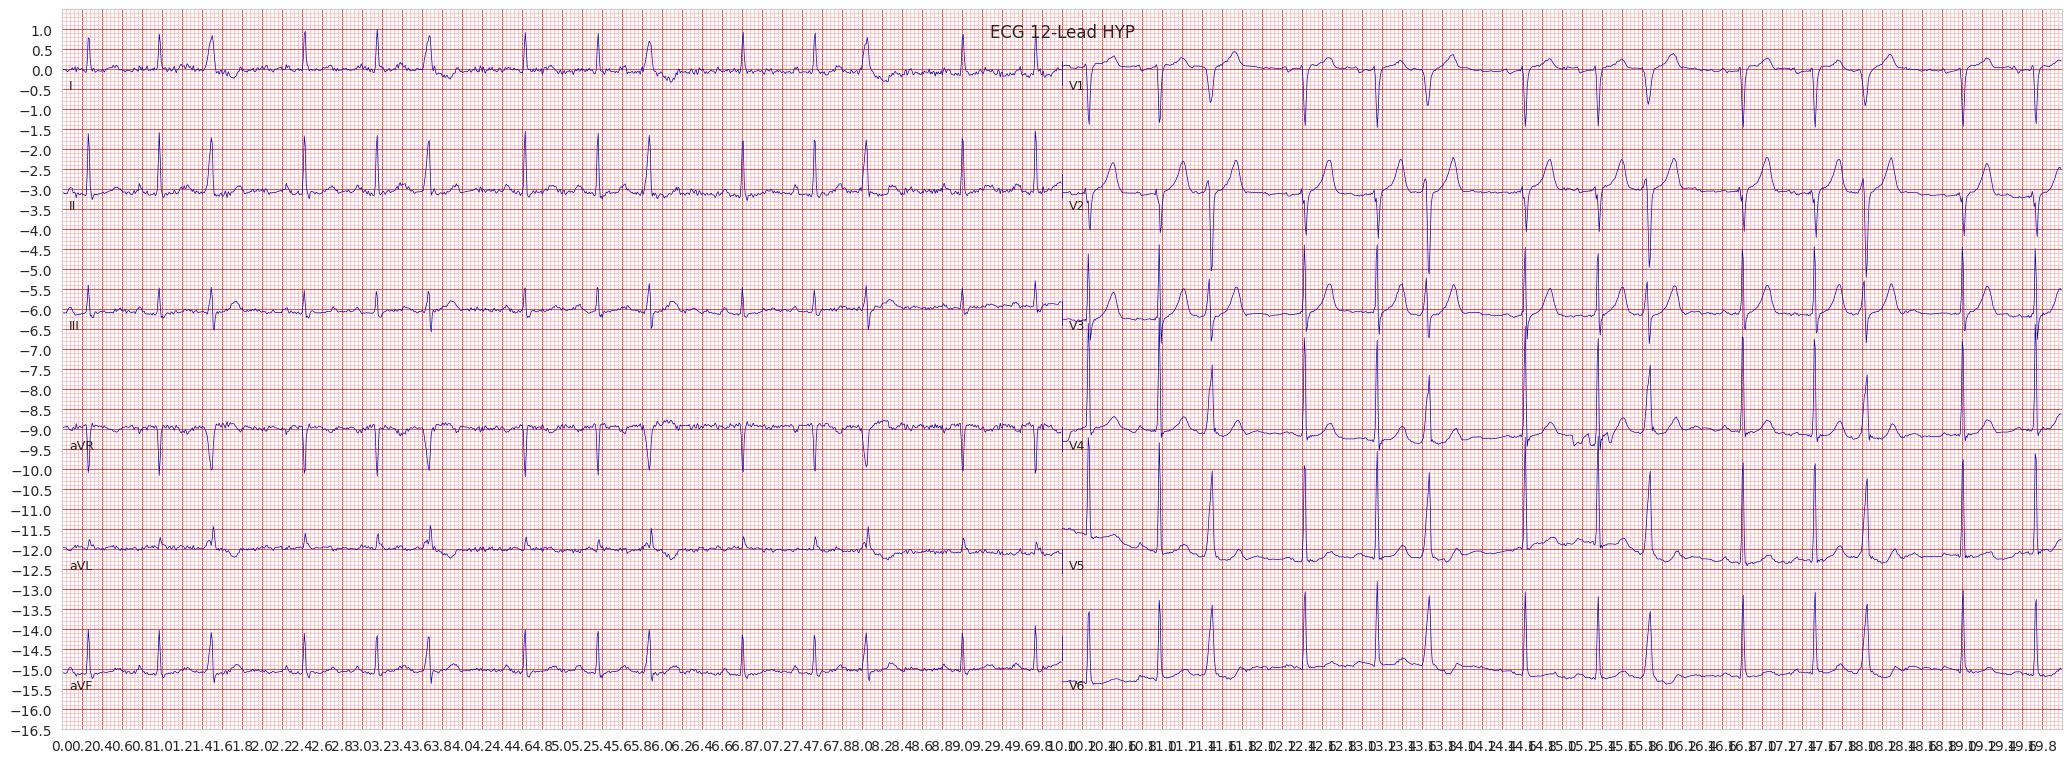

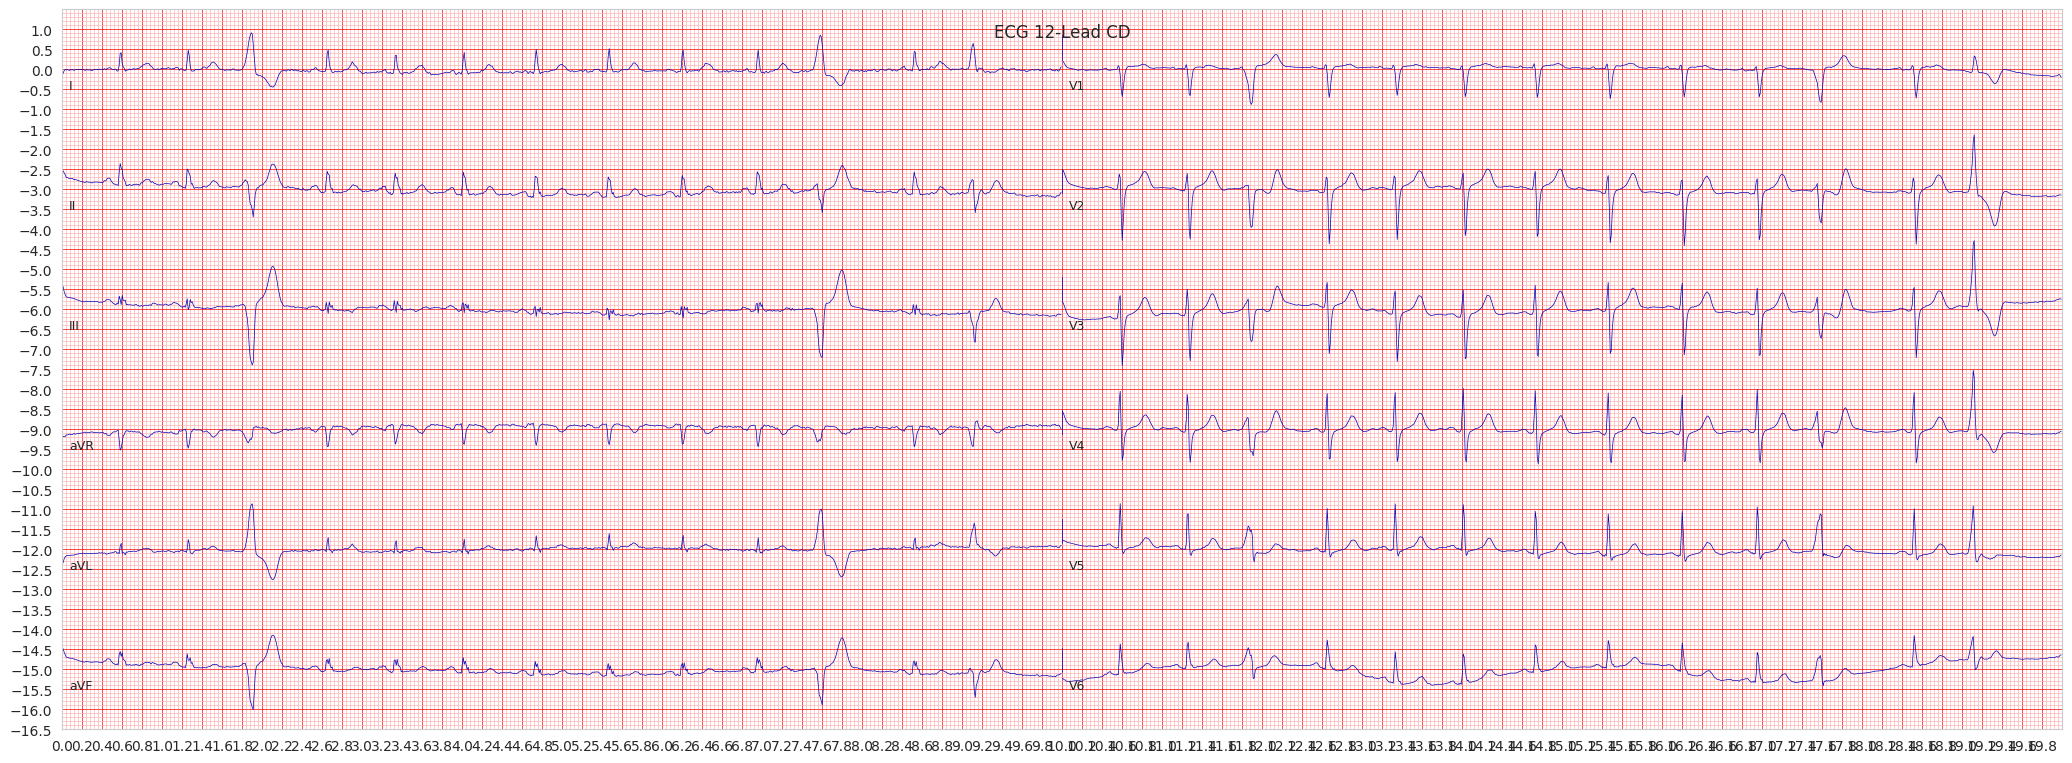

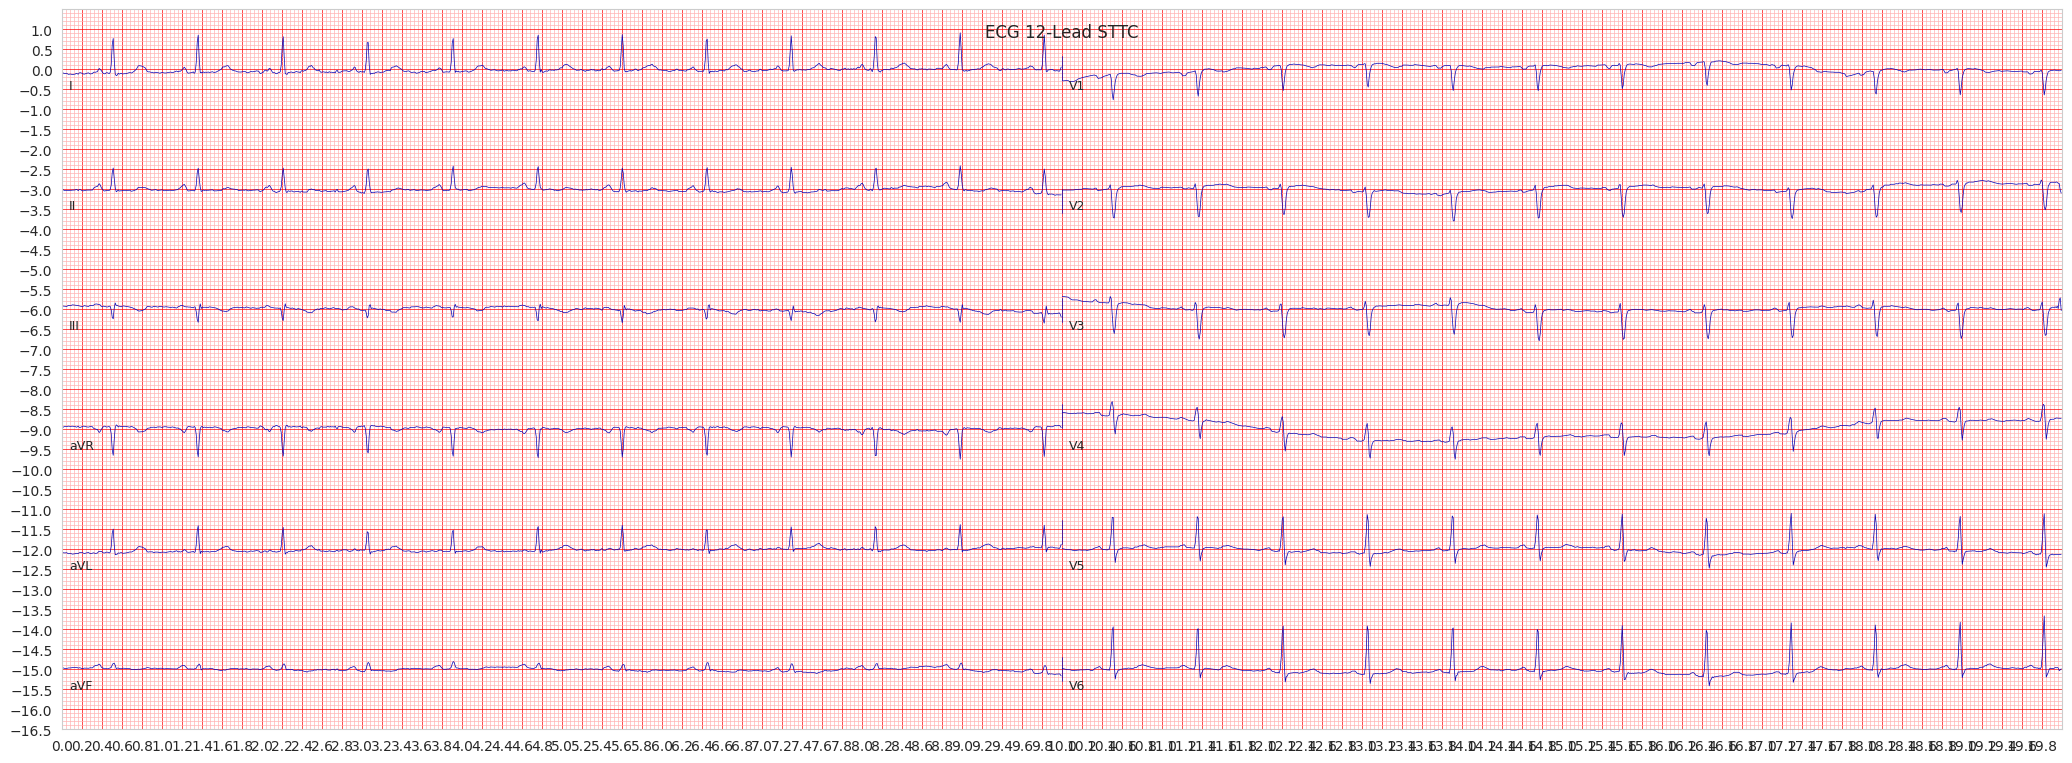

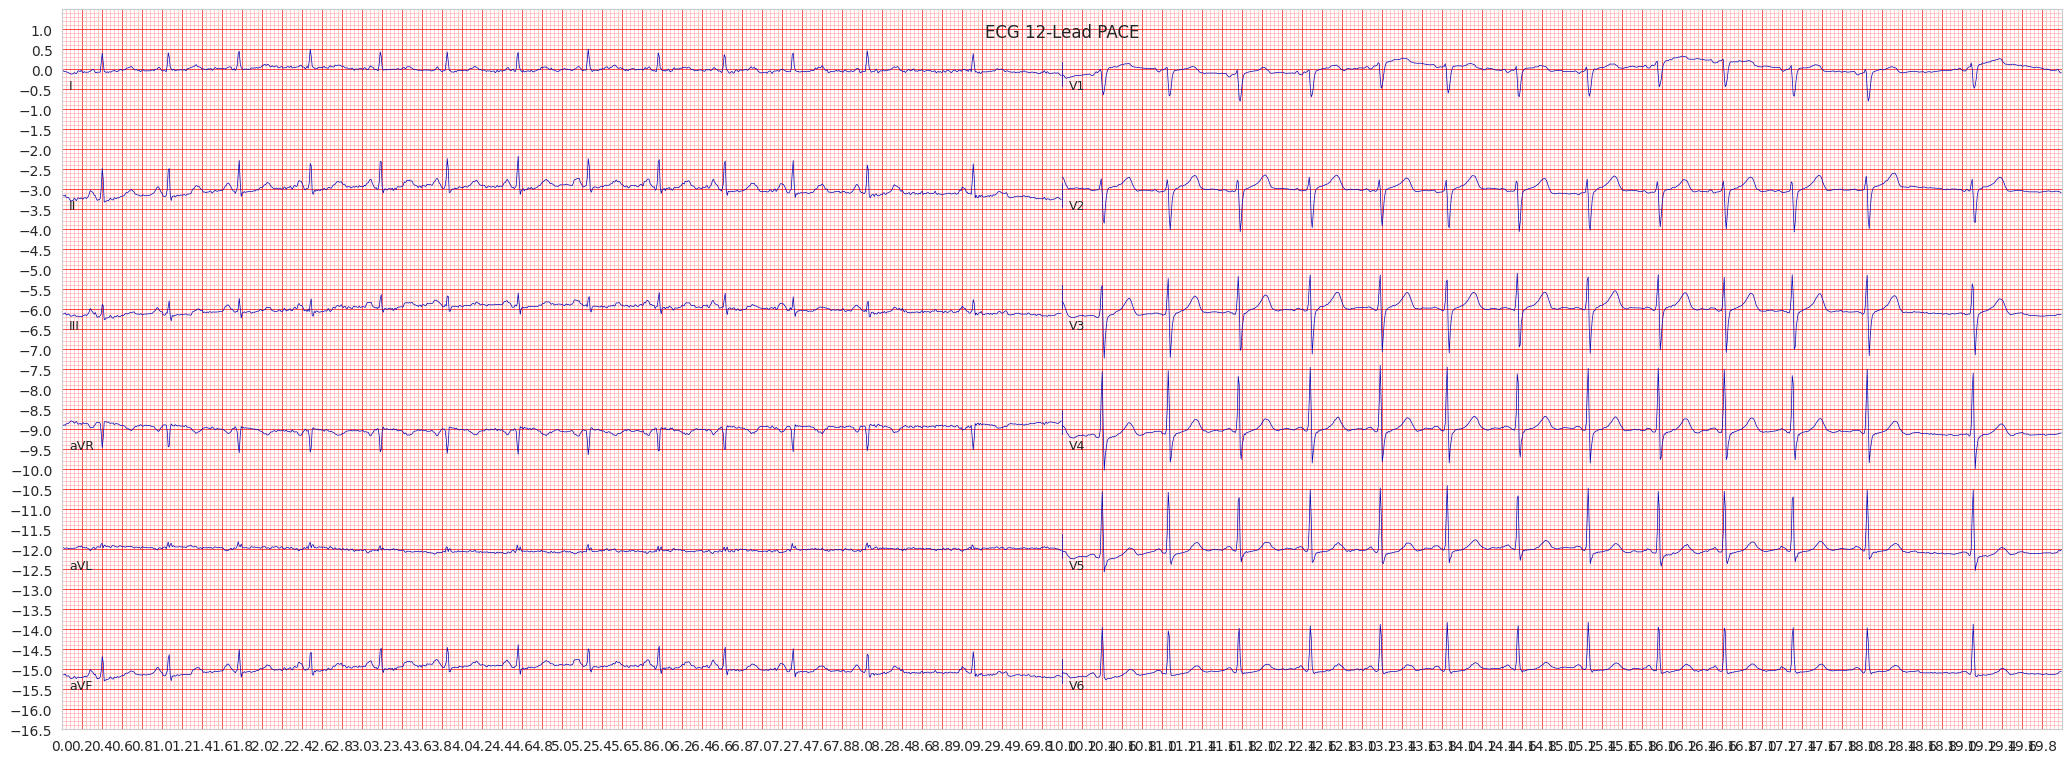

In [17]:
sample_id = 100
plot_ecg_12_lead(ecg_norm[sample_id], title='ECG 12-Lead NORM')
plot_ecg_12_lead(ecg_mi[sample_id], title='ECG 12-Lead MI')
plot_ecg_12_lead(ecg_hyp[sample_id], title='ECG 12-Lead HYP')
plot_ecg_12_lead(ecg_cd[sample_id], title='ECG 12-Lead CD')
plot_ecg_12_lead(ecg_sttc[sample_id], title='ECG 12-Lead STTC')
plot_ecg_12_lead(ecg_pace, title='ECG 12-Lead PACE')

# Preprocess

Explain

In [24]:
mlb = MultiLabelBinarizer()
mlb.fit(Y_data["diagnostic_superclass"])
y = mlb.transform(Y_data["diagnostic_superclass"].values)

In [25]:
Y_data.diagnostic_superclass.iloc[80:82]

ecg_id
86        [NORM]
87    [STTC, CD]
Name: diagnostic_superclass, dtype: object

In [26]:
y[80:82]

array([[0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1]])

In [27]:
mlb.classes_

array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object)

## Train-Valid-Test Set Splitting
According to the source of the dataset, there are recommended stratified 10-folds, where the same patients are kept within the same folds. Moreover, 9th fold and 10th are of higher quality, which are recommeded to be used as validation set and test set.

> Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

Here, I will split compile fold 1-8 as train sets, fold 9 as validation set, and fold 10 as test set.

In [28]:
    # Stratified split
    X_train = X_data[Y_data.strat_fold < 9]
    y_train = y[Y_data.strat_fold < 9]

    X_val = X_data[Y_data.strat_fold == 9]
    y_val = y[Y_data.strat_fold == 9]

    X_test = X_data[Y_data.strat_fold == 10]
    y_test = y[Y_data.strat_fold == 10]

In [29]:
def apply_scaler(inputs: np.array, scaler: StandardScaler) -> np.array:
    """Applies standardization to each individual ECG signal.
    Parameters
    ----------
    inputs: np.array
        Array of ECG signals.
    scaler: StandardScaler
        Standard scaler object.
    Returns
    -------
    np.array
        Array of standardized ECG signals.
    """

    temp = []
    for x in inputs:
        x_shape = x.shape
        temp.append(scaler.transform(x.flatten()[:, np.newaxis]).reshape(x_shape))
    temp = np.array(temp)
    return temp

In [30]:
    # Standardization
    scaler = StandardScaler()
    scaler.fit(np.vstack(X_train).flatten()[:, np.newaxis].astype(float))
    X_train_scale = apply_scaler(X_train, scaler)
    X_test_scale = apply_scaler(X_test, scaler)
    X_val_scale = apply_scaler(X_val, scaler)

In [ ]:
# Se podrían borrar para liberar memoria
# del X_data, Y_data, y, data
# del X_train, X_test, X_val


### Save variables for later

In [31]:
path_variable_pickle = 'data/variables_pickle/'
files = [
    ('X_train_scale', 'X_train_scale.pkl'),
    ('y_train', 'y_train.pkl'),
    ('X_val_scale', 'X_val_scale.pkl'),
    ('y_val', 'y_val.pkl'),
    ('X_test_scale', 'X_test_scale.pkl'),
    ('y_test', 'y_test.pkl'),
    ('X', 'X.pkl'),
    ('Y', 'Y.pkl'),
]

for variable, file in files:
    with open(path_variable_pickle + file, 'wb') as f:
        pickle.dump(eval(variable), f)


# Check data

In [24]:
for f, _ in files:
    print(f"{f}: {eval(f).shape}")

X_train_scale: (17090, 1000, 12)
y_train: (17090, 5)
X_test_scale: (2159, 1000, 12)
y_test: (2159, 5)
X_val_scale: (2147, 1000, 12)
y_val: (2147, 5)
X: (21801, 1000, 12)
Y: (21801, 47)


# References

[1]	ECG plot: https://github.com/dy1901/ecg_plot
